# Pre-processing

## Libraries and Functions

In [1]:
# NumPy, SciPy and Pandas
import numpy as np
import pandas as pd
import seaborn as sns

# Scikit-Learn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import linear_model  
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree

# import required libraries
import matplotlib.pyplot as plt
from collections import Counter

# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout

DEFAULT_K = 10

"""
# Get instance with only one target class
"""
def findUnitaryClass(y):
    classCounter = Counter(y)
#     print classCounter
    numLeastCommonClass = min(classCounter.values())
    if numLeastCommonClass == 1:
        # update for python3
        label = list(classCounter.keys())[list(classCounter.values()).index(numLeastCommonClass)]
    else:
        label = -10
    return label

"""
Determine number of folds
"""
def chooseK(train_labels):
    classCounter = Counter(train_labels)
    numLeastCommonClass = min(classCounter.values())
    return min(numLeastCommonClass, DEFAULT_K)

"""
Compute different validation metrics for a classification problem.
Metrics:
- micro and macro F1 score
- Confusion Matrix
- Classification Report
"""
def getClfMetrics(test_labels, pred_labels):
    acc = accuracy_score(test_labels, pred_labels) 
    print("\nAccuracy (f1 micro) on test set: {}".format(acc.round(2)))
    print("F1 micro on test set: {}".format(f1_score(test_labels, 
                                                     pred_labels, 
                                                     average = 'micro').round(2)))
    print("F1 macro on test set: {}".format(f1_score(test_labels, 
                                                     pred_labels, 
                                                     average = 'macro').round(2)))
    print("\nConfusion Matrix: ")
    print(confusion_matrix(test_labels, pred_labels))#, labels = [-2, -1, 0, 1, 2])
    print("\nClassification Metrics: ")
    print(classification_report(test_labels, pred_labels))

    return acc

"""
Choose the best combination of parameters for a given model
"""
def selectModelParameters(train_vectors, train_labels, trainclf, parameters, 
                          scorer, useSampleWeight = False):
    k = chooseK(train_labels) # get number of folds
    print("Number of folds: " + str(k))
    stratifiedKFold = StratifiedKFold(n_splits = k)
    if useSampleWeight:
        n_samples = len(train_labels)
        n_classes = len(set(train_labels))
        classCounter = Counter(train_labels)
        sampleWeights = [n_samples / (n_classes * classCounter[label]) for label in train_labels]
        gridSearch = GridSearchCV(trainclf, parameters, cv = stratifiedKFold, 
                                  scoring = scorer, fit_params = {'sample_weight' : sampleWeights})
    else:
        gridSearch = GridSearchCV(trainclf, parameters, cv = stratifiedKFold, scoring = scorer)
    
    gridSearch.fit(train_vectors, train_labels)
    print( "Best parameters set found on development set:")
    print( gridSearch.best_params_)
#     print "\nGrid scores on development set using " + scorer + " : "
#     for params, mean_score, scores in gridSearch.grid_scores_:
#         print "%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params)
    
    return gridSearch.best_estimator_

"""
Choose the optimal depth of a tree model 
"""
def chooseOptimalTreeDepth(clf, train_vectors, train_labels, plot = True):
    # generate a list of potential depths to calculate the optimal
    depths = list(range(1, 25))

    # empty list that will hold cv scores
    cv_scores = []

    # find optimal tree depth
    for d in depths: # TODO: try using chooseK(train_labels) instead of jus DEFAULT_K
        clf_depth = clf.set_params(max_depth = d) # use previous parameters while changing depth
        # accuracy here is f1 micro
        scores = cross_val_score(clf_depth, train_vectors, train_labels, 
                                 cv = chooseK(train_labels), scoring = 'accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error and determining best depth
    MSE = [1 - x for x in cv_scores] # MSE = 1 - f1_micro
    optimal_depth = depths[MSE.index(min(MSE))]
    print( "The optimal depth is: ", optimal_depth, "\n")
    print( "Expected accuracy (f1 micro) based on Cross-Validation: ", 
          cv_scores[depths.index(optimal_depth)], "\n")
    
    if plot:
        # plot misclassification error vs depths
        fig = plt.figure(figsize=(12, 10))
        plt.plot(depths, MSE)
        plt.xlabel('Tree Depth', fontsize = 20)
        plt.ylabel('Misclassification Error', fontsize = 20)
        plt.legend(fontsize = 15)
        plt.show()

    return optimal_depth

def MLPsklearn(dataframe, holistic=True):
    df = dataframe.copy()
    if holistic:
        del df['Participant_No']
        
    num_features = len(list(df)[:-1]) - 1 
        
    # form the matrices
    X = np.array(df.iloc[:, 0:num_features])
    y = np.array(df['Discrete Thermal Comfort_TA'])
    
    # MLP is sensitive to feature scaling.
    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(X) # TODO: does this take care of boolean variables?

    # split into train and test
    test_size_percentage = 0.3

    # X_train = train + cv set
    # X_test = test set
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                        test_size = test_size_percentage, 
                                                        random_state = 100, stratify = y)

    # Using sklearn library
    h_neurons = 10 # TODO: for loop to choose best architecture

    mlp = MLPClassifier(hidden_layer_sizes = (h_neurons,), # 1 hidden layer
                        activation = 'relu', 
                        solver = 'lbfgs', 
                        alpha = 0.001, 
                        learning_rate_init = 0.001, # only used with solver adam or sgd
                        max_iter = 300,
                        momentum=0.9,
                        random_state = 100)

    # model learned
    print(mlp)

    # k-fold cross validation
    # accuracy here is f1 micro
    scores = cross_val_score(mlp, X_train, y_train, cv = DEFAULT_K, scoring = 'accuracy')
    print("\nExpected accuracy (f1 micro) based on Cross-Validation: ".format(scores.mean()))

    # fitting the model
    mlp.fit(X_train, y_train)

    # predict the response
    y_pred = mlp.predict(X_test)

    # Metrics
    acc = getClfMetrics(y_test, y_pred)
    
    return acc

"""
Learn Random Forest, choose the best hyperparameters and lastly the depth of the trees
and returns the acc
"""
def learnRF(dataframe, num_features, binary=False):
    X = np.array(dataframe.iloc[:, 0:num_features])
    if binary:
        y = np.array(dataframe['Discomfort'])
    else:
        # TODO: should be updated to only look at final column
        y = np.array(dataframe['Discrete Thermal Comfort_TA'])

    # split into train and test
    test_size_percentage = 0.3 

    # X_train = train + cv set (train_vectors)
    # X_test = test set (test_vectors)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size_percentage, 
                                                        random_state = 100, stratify = y)

    parameters = {'n_estimators' : [10, 100, 1000],
                  'criterion' : ['entropy', 'gini'],
                  'min_samples_split' : [2, 10, 20, 30], 
                  'class_weight' : ['balanced', 'balanced_subsample']}
    scorer = 'f1_micro'
    
    clf = RandomForestClassifier(n_estimators = 10, min_samples_split = 2, 
                                 class_weight = 'balanced', random_state = 100)
    rf_classifier = selectModelParameters(X_train, y_train, clf, parameters, scorer)

    # find optimal depth and generate model
    optimal_depth = chooseOptimalTreeDepth(rf_classifier, X_train, y_train)

    # generate the model with the selected paramters plus the optimal depth and do the model fitting
    rf_optimal = rf_classifier.set_params(max_depth = optimal_depth)
    print(rf_optimal)
    rf_optimal.fit(X_train, y_train)

    # predict the response on test set
    y_pred = rf_optimal.predict(X_test)

    # get metrics
    return getClfMetrics(y_test, y_pred)

"""
Learn KNN
"""
def learnKNN(dataframe, num_feature, binary=False):
    # create design matrix X and target vector y
    X = np.array(dataframe.iloc[:, 0:num_feature])
    if binary:
        y = np.array(dataframe['Discomfort'])
    else:
        # TODO: should be updated to only look at final column
        y = np.array(dataframe['Discrete Thermal Comfort_TA'])
    
    # split into train and test
    test_size_percentage = 0.3 

    # X_train = train + cv set (train_vectors)
    # X_test = test set (test_vectors)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size_percentage, 
                                                        random_state = 100, stratify = y)

    parameters = {'n_neighbors' : [3, 5, 7, 9, 10, 11, 12, 13, 14, 15], 
                  'weights' : ['uniform', 'distance'], 
                  'metric' : ['seuclidean'], 'algorithm' : ['brute']}
    scorer = 'f1_micro'
    clf = KNeighborsClassifier(n_neighbors = 3, weights = 'uniform', metric = 'seuclidean', 
                               algorithm = 'brute')
    knn_classifier = selectModelParameters(X_train, y_train, clf, parameters, scorer)

    # fitting the model
    knn_classifier.fit(X_train, y_train)
    print("\n")
    print(knn_classifier)

    # predict the response
    y_pred = knn_classifier.predict(X_test)

    # evaluate accuracy
    return getClfMetrics(y_test, y_pred)

"""
Learn Support Vector Machines
"""
def learnSVM(dataframe, num_feature, binary=False):
    # create design matrix X and target vector y
    X = np.array(dataframe.iloc[:, 0:num_feature])
    if binary:
        y = np.array(dataframe['Discomfort'])
    else:
        # TODO: should be updated to only look at final column
        y = np.array(dataframe['Discrete Thermal Comfort_TA'])


    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(X) # TODO: does this take care of boolean variables?

    # split into train and test
    test_size_percentage = 0.3

    # X_train = train + cv set (train_vectors)
    # X_test = test set (test_vectors)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                        test_size = test_size_percentage, 
                                                        random_state = 100, stratify = y)

    parameters = [{'C' : [1, 10, 100, 1000],
                   'kernel' : ['linear'], 
                   'class_weight' : ['balanced']},
                  {'C' : [1, 10, 100, 1000], 
                   'kernel' : ['rbf'], 
                   'gamma' : [0.1, 0.01, 0.001, 0.0001], 
                   'class_weight' : ['balanced']}]
    clf = SVC(C = 1, kernel = 'linear', class_weight = None, random_state = 100)
    scorer = 'f1_micro'
    svm_classifier = selectModelParameters(X_train, y_train, clf, parameters, scorer)

    # fitting the model
    svm_classifier.fit(X_train, y_train)
    print("\n")
    print(svm_classifier)

    # predict the response
    y_pred = svm_classifier.predict(X_test)

    # evaluate accuracy
    return getClfMetrics(y_test, y_pred)

"""
Learn Naive-Bayes
"""
def learnNB(dataframe, num_feature, binary=False):
    # create design matrix X and target vector y
    X = np.array(dataframe.iloc[:, 0:num_feature])
    if binary:
        y = np.array(dataframe['Discomfort'])
    else:
        # TODO: should be updated to only look at final column
        y = np.array(dataframe['Discrete Thermal Comfort_TA'])


    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(X) # TODO: does this take care of boolean variables?

    # split into train and test
    test_size_percentage = 0.3

    # X_train = train + cv set
    # X_test = test set
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                        test_size = test_size_percentage, 
                                                        random_state = 100, stratify = y)

    # instantiate learning model
    nb_classifier = GaussianNB() # TODO get priors?

    # k-fold cross validation
    # accuracy here is f1 micro
    scores = cross_val_score(nb_classifier, X_train, y_train, cv = DEFAULT_K, scoring = 'accuracy')
    print("Expected accuracy (f1 micro) based on Cross-Validation: {}".format(scores.mean()))

    # fitting the model
    nb_classifier.fit(X_train, y_train)
    print("\n")
    print(nb_classifier)

    # predict the response
    y_pred = nb_classifier.predict(X_test)

    # Metrics
    return getClfMetrics(y_test, y_pred)

"""
Learn MLP
"""
def learnMLP(dataframe, num_feature, binary=False):
    # create design matrix X and target vector y
    X = np.array(dataframe.iloc[:, 0:num_feature]) # since we are not using participant, -1
    if binary:
        y = np.array(dataframe['Discomfort'])
    else:
        # TODO: should be updated to only look at final column
        y = np.array(dataframe['Discrete Thermal Comfort_TA'])


    # MLP is sensitive to feature scaling. 
    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(X) # TODO: does this take care of boolean variables?

    # split into train and test
    test_size_percentage = 0.3

    # X_train = train + cv set
    # X_test = test set
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                        test_size = test_size_percentage, 
                                                        random_state = 100, stratify = y)

    # # MLP for multi-class softmax classification
    # # Dense(64) is a fully-connected layer with 64 hidden units.
    # # in the first layer, you must specify the expected input data shape
    # model.add(Dense(20, activation='relu', input_dim = 8))
    # model.add(Dropout(0.5))
    # model.add(Dense(20, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(5, activation='softmax'))

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    # model.compile(loss='sparse_categorical_crossentropy',
    #               optimizer=sgd,
    #               metrics=['accuracy'])

    # model.fit(X_train, y_train,
    #           epochs = 20,
    #           batch_size = 128)

    # # fitting the model
    # model.fit(X_train, y_train, epochs = 20, batch_size = 128)

    # # predict the response
    # y_pred = model.predict(X_test)

    # # evaluate the model
    # mlp_acc_1 = getClfMetrics(y_test, y_pred)

    # Using sklearn library
    mlp = MLPClassifier(hidden_layer_sizes = (11,), # 1 hidden layer with 8 neurons
                        activation = 'tanh', 
                        solver = 'lbfgs', 
                        alpha = 0.001, 
                        learning_rate_init = 0.001, # only used with solver adam or sgd
                        max_iter = 300,
                        verbose = True,
                        random_state = 100)

    # model learned
    print(mlp)

    # k-fold cross validation
    # accuracy here is f1 micro
    scores = cross_val_score(mlp, X_train, y_train, cv = DEFAULT_K, scoring = 'accuracy')
    print("\nExpected accuracy (f1 micro) based on Cross-Validation: ", scores.mean(), "\n")

    # fitting the model
    mlp.fit(X_train, y_train)

    # predict the response
    y_pred = mlp.predict(X_test)

    # Metrics
    return getClfMetrics(y_test, y_pred)

"""
Participant version of learning RF
"""
def participantRF(dataframe, num_feature, participant_list, binary=False):
    dict_rf_classifier = {}
    dict_rf_classifier_acc = {}
    
    for participant in participant_list:
        print("Starting Participant " + str(participant))

        df_participant = dataframe[dataframe['Participant_No'] == participant]    
        del df_participant['Participant_No'] # do not use the Particiant_No as a feature

        # check if there are classes with only one sample
        label_to_remove = findUnitaryClass(df_participant['Discrete Thermal Comfort_TA'])
        if label_to_remove != -10: # value used when no unitary class was find
            df_participant = df_participant[df_participant['Discrete Thermal Comfort_TA'] != label_to_remove]
            print("Participant " + str(participant) + " has label " + str(label_to_remove) + " as unitary class.\n")

        # create design matrix X and target vector y
        X = np.array(df_participant.iloc[:, 0:num_feature])
        y = np.array(df_participant['Discrete Thermal Comfort_TA'])

        # split into train and test
        test_size_percentage = 0.3 

        # X_train = train + cv set (train_vectors)
        # X_test = test set (test_vectors)
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size = test_size_percentage, 
                                                            random_state = 100, stratify = y)

        # ignore if only 1 fold is found
        if chooseK(y_train) == 1:
            print("Participant " + str(participant) + " only had one fold.\n")
            continue

        parameters = {'n_estimators' : [5, 10, 100, 1000],
                      'criterion' : ['entropy', 'gini'],
                      'min_samples_split' : [2, 10, 20, 30], 
                      'class_weight' : ['balanced', 'balanced_subsample']}
        scorer = 'f1_micro'
        clf = RandomForestClassifier(n_estimators = 5, min_samples_split = 2, 
                                     class_weight = 'balanced', random_state = 100)
        dict_rf_classifier[participant] = selectModelParameters(X_train, y_train, clf, 
                                                                parameters, scorer)
        print("\n")

        # find optimal depth and generate model
        optimal_depth = chooseOptimalTreeDepth(dict_rf_classifier[participant], 
                                               X_train, y_train, plot = False)

        # generate the model with the selected parameters plus the optimal depth and 
        # do the model fitting
        rf_optimal = dict_rf_classifier[participant].set_params(max_depth = optimal_depth)
    #     print rf_optimal
        rf_optimal.fit(X_train, y_train)

        # predict the response on test set
        y_pred = rf_optimal.predict(X_test)

        # Metrics
        rf_acc_subject = accuracy_score(y_test, y_pred)
        # store the accuracy of the respective participant
        dict_rf_classifier_acc[participant] = rf_acc_subject
        print("\n")
        
        # end of for loop
        
    return dict_rf_classifier_acc
    

## Loading File

In [2]:
# load merged file
df = pd.read_csv("../datasets/TCS_65_participants_outsideData.csv", delimiter = ",")

# drop columns with no use for modelling
del df['timestamp']
del df['Day']
del df['Time Broken']
del df['Day_Time']
del df['Text(Day_Time)']
del df['Total Seconds']
del df['Diff Seconds']
del df['Temperature']
del df['ThermalComfort']
del df['TopClothing']
del df['BottomClothing']
del df['OuterLayerClothing']
del df['ActivityDescription']
del df['Thermal Comfort TA']

df.reset_index()# reset index
df = df.fillna(0) # fill NaN with 0

# encoding categorical variables 
df_encoded = df.copy()
for col in df_encoded.columns.values:
    le = LabelEncoder()
    # don't change the class type
    if df_encoded[col].dtypes == 'object' and df_encoded[col].name != 'class': 
        df_encoded[col] = df_encoded[col].astype(str)
        le.fit(df_encoded[col])
        df_encoded[col]=le.transform(df_encoded[col])


In [3]:
df_encoded.head(10)

,Participant_No,class,Temperature (Fahrenheit),MinuteCalories,Gsr,SkinTemperature,ClothingInsulation,Activity,Height(cm),Shoulder Circumference(cm),Weight(lbs),Gender,Temperature_outside,Humidity_outside,Discrete Thermal Comfort_TA
0,1,BandData,64.059998,1.052632,7362.000000,87.179001,0.00,0,165.1,111.6,200.0,0,73.690002,75.699997,0
1,1,SurveyData,64.059998,1.052632,7362.000000,87.179001,0.32,3,165.1,111.6,200.0,0,73.690002,75.699997,0
2,1,BandData,64.000000,1.551724,6818.666667,87.446001,0.00,0,165.1,111.6,200.0,0,73.690002,75.699997,0
3,1,BandData,63.270000,1.371429,8095.666667,87.356000,0.00,0,165.1,111.6,200.0,0,73.690002,75.699997,0
4,1,BandData,62.880001,1.545064,8281.750000,87.458000,0.00,0,165.1,111.6,200.0,0,73.690002,75.699997,0
5,1,BandData,62.150002,1.438356,9770.666667,87.571999,0.00,0,165.1,111.6,200.0,0,73.690002,75.699997,0
6,1,BandData,62.279999,1.367521,10915.666670,87.506000,0.00,0,165.1,111.6,200.0,0,73.690002,75.699997,0
7,1,BandData,62.150002,1.466993,12250.000000,87.440001,0.00,0,165.1,111.6,200.0,0,73.690002,75.699997,0
8,1,BandData,61.720001,1.410256,13847.833330,87.650000,0.00,0,165.1,111.6,200.0,0,73.690002,75.699997,0
9,1,SurveyData,62.020000,1.482890,16630.000000,88.063999,0.32,7,165.1,111.6,200.0,0,73.690002,75.699997,0


# Feature Set Selection

## Feature set 1: Biometrics + environmental

In [4]:
df_feature1 = df_encoded.copy()

# since the activity feature is heavily imbalaced
del df_feature1['Activity']
del df_feature1['Gsr'] # when doing linear regression, Gsr had the lowest coefficient
del df_feature1['MinuteCalories'] # not used anymore

feature_set1 = list(df_feature1)[:-1] # don't count target
num_feature_set1 = len(feature_set1) - 2 # don't count the participant number as feature nor class
print("Feature Set 1 considers all features measured by the health band and phone survey")
print("Feature Set 1: {}".format(feature_set1))
print("Number of features in this set: {}".format(num_feature_set1))


Feature Set 1 considers all features measured by the health band and phone survey
Feature Set 1: ['Participant_No', 'class', 'Temperature (Fahrenheit)', 'SkinTemperature', 'ClothingInsulation', 'Height(cm)', 'Shoulder Circumference(cm)', 'Weight(lbs)', 'Gender', 'Temperature_outside', 'Humidity_outside']
Number of features in this set: 9


In [31]:
df_feature1_to = df_encoded.copy()

# since the activity feature is heavily imbalaced
del df_feature1_to['Activity']
del df_feature1_to['Gsr'] # when doing linear regression, Gsr had the lowest coefficient
del df_feature1_to['MinuteCalories'] # not used anymore
del df_feature1_to['Humidity_outside']

feature_set1_to = list(df_feature1_to)[:-1] # don't count target
num_feature_set1_to = len(feature_set1_to) - 2 # don't count the participant number as feature nor class
print("Feature Set 1 considers all features measured by the health band and phone survey")
print("Feature Set 1: {}".format(feature_set1_to))
print("Number of features in this set: {}".format(num_feature_set1_to))


Feature Set 1 considers all features measured by the health band and phone survey
Feature Set 1: ['Participant_No', 'class', 'Temperature (Fahrenheit)', 'SkinTemperature', 'ClothingInsulation', 'Height(cm)', 'Shoulder Circumference(cm)', 'Weight(lbs)', 'Gender', 'Temperature_outside']
Number of features in this set: 8


In [32]:
df_feature1_rh = df_encoded.copy()

# since the activity feature is heavily imbalaced
del df_feature1_rh['Activity']
del df_feature1_rh['Gsr'] # when doing linear regression, Gsr had the lowest coefficient
del df_feature1_rh['MinuteCalories'] # not used anymore
del df_feature1_rh['Temperature_outside']

feature_set1_rh = list(df_feature1_rh)[:-1] # don't count target
num_feature_set1_rh = len(feature_set1_rh) - 2 # don't count the participant number as feature nor class
print("Feature Set 1 considers all features measured by the health band and phone survey")
print("Feature Set 1: {}".format(feature_set1_rh))
print("Number of features in this set: {}".format(num_feature_set1_rh))


Feature Set 1 considers all features measured by the health band and phone survey
Feature Set 1: ['Participant_No', 'class', 'Temperature (Fahrenheit)', 'SkinTemperature', 'ClothingInsulation', 'Height(cm)', 'Shoulder Circumference(cm)', 'Weight(lbs)', 'Gender', 'Humidity_outside']
Number of features in this set: 8


## Feature Set 2: Weak-biometrics (height and shoulder circumference) + Environmental

In [5]:
df_feature2 = df_feature1.copy()

# reduce feature so it fitts Feature Set2 description
# del df_feature2['MinuteCalories'] # already been discarded
del df_feature2['Weight(lbs)']
del df_feature2['SkinTemperature']
del df_feature2['ClothingInsulation']
del df_feature2['Gender']

feature_set2 = list(df_feature2)[:-1] # don't count target label
num_feature_set2 = len(feature_set2) - 2 # don't count the participant number as feature nor class

print("Feature Set 2 only takes into account the features that FORK can potentially extract from people")
print("Feature Set 2: {}".format(feature_set2))
print("Number of features in this set: {}".format(num_feature_set2))


Feature Set 2 only takes into account the features that FORK can potentially extract from people
Feature Set 2: ['Participant_No', 'class', 'Temperature (Fahrenheit)', 'Height(cm)', 'Shoulder Circumference(cm)', 'Temperature_outside', 'Humidity_outside']
Number of features in this set: 5


In [33]:
df_feature2_to = df_feature1_to.copy()

# reduce feature so it fitts Feature Set2 description
# del df_feature2['MinuteCalories'] # already been discarded
del df_feature2_to['Weight(lbs)']
del df_feature2_to['SkinTemperature']
del df_feature2_to['ClothingInsulation']
del df_feature2_to['Gender']

feature_set2_to = list(df_feature2_to)[:-1] # don't count target label
num_feature_set2_to = len(feature_set2_to) - 2 # don't count the participant number as feature nor class

print("Feature Set 2 only takes into account the features that FORK can potentially extract from people")
print("Feature Set 2: {}".format(feature_set2_to))
print("Number of features in this set: {}".format(num_feature_set2_to))


Feature Set 2 only takes into account the features that FORK can potentially extract from people
Feature Set 2: ['Participant_No', 'class', 'Temperature (Fahrenheit)', 'Height(cm)', 'Shoulder Circumference(cm)', 'Temperature_outside']
Number of features in this set: 4


In [34]:
df_feature2_rh = df_feature1_rh.copy()

# reduce feature so it fitts Feature Set2 description
# del df_feature2['MinuteCalories'] # already been discarded
del df_feature2_rh['Weight(lbs)']
del df_feature2_rh['SkinTemperature']
del df_feature2_rh['ClothingInsulation']
del df_feature2_rh['Gender']

feature_set2_rh = list(df_feature2_rh)[:-1] # don't count target label
num_feature_set2_rh = len(feature_set2_rh) - 2 # don't count the participant number as feature nor class

print("Feature Set 2 only takes into account the features that FORK can potentially extract from people")
print("Feature Set 2: {}".format(feature_set2_rh))
print("Number of features in this set: {}".format(num_feature_set2_rh))


Feature Set 2 only takes into account the features that FORK can potentially extract from people
Feature Set 2: ['Participant_No', 'class', 'Temperature (Fahrenheit)', 'Height(cm)', 'Shoulder Circumference(cm)', 'Humidity_outside']
Number of features in this set: 4


## Feature Set 3: Environmental alone

In [6]:
df_feature3 = df_feature2.copy()

# we only care about Temperature and label
del df_feature3['Shoulder Circumference(cm)']
del df_feature3['Height(cm)']

feature_set3 = list(df_feature3)[:-1] # don't count target label
num_feature_set3 = len(feature_set3) - 2 # don't count the participant number as feature nor class

print("Feature Set 3 only uses environmental data")
print("Feature Set 3 (no subjects): {}".format(feature_set3))
print("Number of features in this set: {}".format(num_feature_set3))


Feature Set 3 only uses environmental data
Feature Set 3 (no subjects): ['Participant_No', 'class', 'Temperature (Fahrenheit)', 'Temperature_outside', 'Humidity_outside']
Number of features in this set: 3


In [35]:
df_feature3_to = df_feature2_to.copy()

# we only care about Temperature and label
del df_feature3_to['Shoulder Circumference(cm)']
del df_feature3_to['Height(cm)']

feature_set3_to = list(df_feature3_to)[:-1] # don't count target label
num_feature_set3_to = len(feature_set3_to) - 2 # don't count the participant number as feature nor class

print("Feature Set 3 only uses environmental data")
print("Feature Set 3 (no subjects): {}".format(feature_set3_to))
print("Number of features in this set: {}".format(num_feature_set3_to))


Feature Set 3 only uses environmental data
Feature Set 3 (no subjects): ['Participant_No', 'class', 'Temperature (Fahrenheit)', 'Temperature_outside']
Number of features in this set: 2


In [36]:
df_feature3_rh = df_feature2_rh.copy()

# we only care about Temperature and label
del df_feature3_rh['Shoulder Circumference(cm)']
del df_feature3_rh['Height(cm)']

feature_set3_rh = list(df_feature3_rh)[:-1] # don't count target label
num_feature_set3_rh = len(feature_set3_rh) - 2 # don't count the participant number as feature nor class

print("Feature Set 3 only uses environmental data")
print("Feature Set 3 (no subjects): {}".format(feature_set3_rh))
print("Number of features in this set: {}".format(num_feature_set3_rh))


Feature Set 3 only uses environmental data
Feature Set 3 (no subjects): ['Participant_No', 'class', 'Temperature (Fahrenheit)', 'Humidity_outside']
Number of features in this set: 2


## FeatuerSet 3b: Only indoor Temperature

In [7]:
df_feature3b = df_feature3.copy()

# we only care about Temperature and label
del df_feature3b['Temperature_outside']
del df_feature3b['Humidity_outside']

feature_set3b = list(df_feature3b)[:-1] # don't count target label
num_feature_set3b = len(feature_set3b) - 2 # don't count the participant number as feature nor class

print("Feature Set 3b only uses actual room temperature")
print("Feature Set 3b (no subjects): {}".format(feature_set3b))
print("Number of features in this set: {}".format(num_feature_set3b))


Feature Set 3b only uses actual room temperature
Feature Set 3b (no subjects): ['Participant_No', 'class', 'Temperature (Fahrenheit)']
Number of features in this set: 1


# Instance type filtering

The feature `class` has 3 possible values: SurveyData, BandData, MergedData
- SurveyData: Corresponds to the samples coming from the mobile survey
- BandData: Corresponds to the biometric readings from the smart wristband
- MergedData: Combination of SurveyData and BandData based on timestamp alignment

However, in this `csv` file, `SurveyData` instances already have values for the `BandData` features, these were copied from the `BandData` instances closest in time.


## SurveyData Instances

In [38]:
df_survey_feature_set1 = df_feature1[df_feature1['class'] == 'SurveyData']
del df_survey_feature_set1['class']

df_survey_feature_set1_to = df_feature1_to[df_feature1_to['class'] == 'SurveyData']
del df_survey_feature_set1_to['class']

df_survey_feature_set1_rh = df_feature1_rh[df_feature1_rh['class'] == 'SurveyData']
del df_survey_feature_set1_rh['class']

df_survey_feature_set2 = df_feature2[df_feature2['class'] == 'SurveyData']
del df_survey_feature_set2['class']

df_survey_feature_set2_to = df_feature2_to[df_feature2_to['class'] == 'SurveyData']
del df_survey_feature_set2_to['class']

df_survey_feature_set2_rh = df_feature2_rh[df_feature2_rh['class'] == 'SurveyData']
del df_survey_feature_set2_rh['class']

df_survey_feature_set3 = df_feature3[df_feature3['class'] == 'SurveyData']
del df_survey_feature_set3['class']

df_survey_feature_set3b = df_feature3b[df_feature3b['class'] == 'SurveyData']
del df_survey_feature_set3b['class']

print("Number of instances: {}".format(df_survey_feature_set1.shape[0]))

Number of instances: 1770


## BandData Instances

Using `BandData` instances is more beneficious since it allows us to use far more instances than with `SurveyData` (the survey was taken every 15 minutes and the smart wristband colleted data every minute).

However, the assumption we need to make is that, between `SurveyData` instances, the thermal comfort label remains constant. This means that for all `BandData` instances inbetween, the thermal comfort label value comes from the latest `SurveyData` instance.

In [9]:
df_band_feature_set1 = df_feature1[df_feature1['class'] == 'BandData']
del df_band_feature_set1['class']

df_band_feature_set2 = df_feature2[df_feature2['class'] == 'BandData']
del df_band_feature_set2['class']

df_band_feature_set3 = df_feature3[df_feature3['class'] == 'BandData']
del df_band_feature_set3['class']

df_band_feature_set3b = df_feature3b[df_feature3b['class'] == 'BandData']
del df_band_feature_set3b['class']

print("Number of instances: {}".format(df_band_feature_set1.shape[0]))

Number of instances: 5319


# Descriptive Statistics

Number of participants: 65
Dataset description: 
        Participant_No       class  Temperature (Fahrenheit)  MinuteCalories  \
count      1770.000000        1770               1770.000000     1770.000000   
unique             NaN           1                       NaN             NaN   
top                NaN  SurveyData                       NaN             NaN   
freq               NaN        1770                       NaN             NaN   
mean         41.020904         NaN                 71.382949        1.238485   
std          24.370448         NaN                  6.273718        0.714473   
min           1.000000         NaN                 60.070000        0.000000   
25%          19.000000         NaN                 65.500000        1.052632   
50%          43.000000         NaN                 70.199997        1.212122   
75%          63.000000         NaN                 77.599998        1.249618   
max          80.000000         NaN                 85.000000        9.3

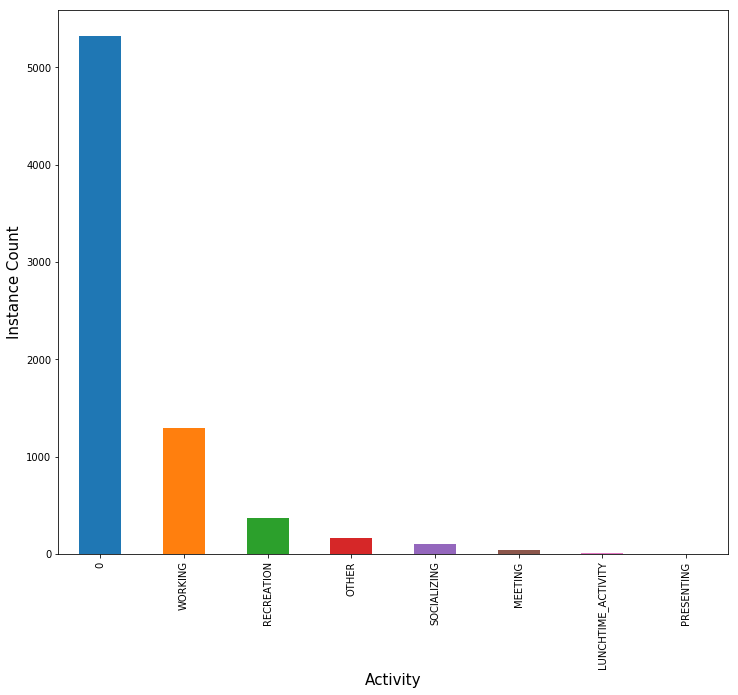

[Female]    39
[Male]      26
Name: Gender, dtype: int64


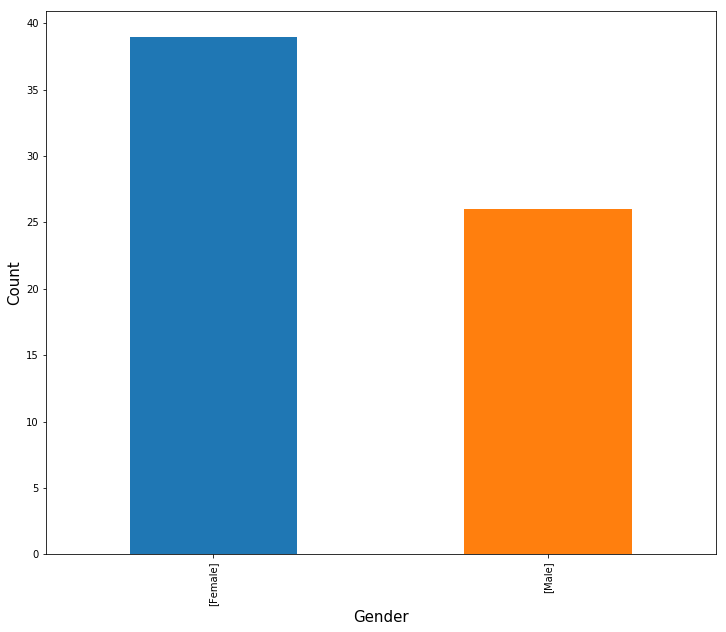

 0    968
-1    405
-2    196
 1    165
 2     36
Name: Discrete Thermal Comfort_TA, dtype: int64


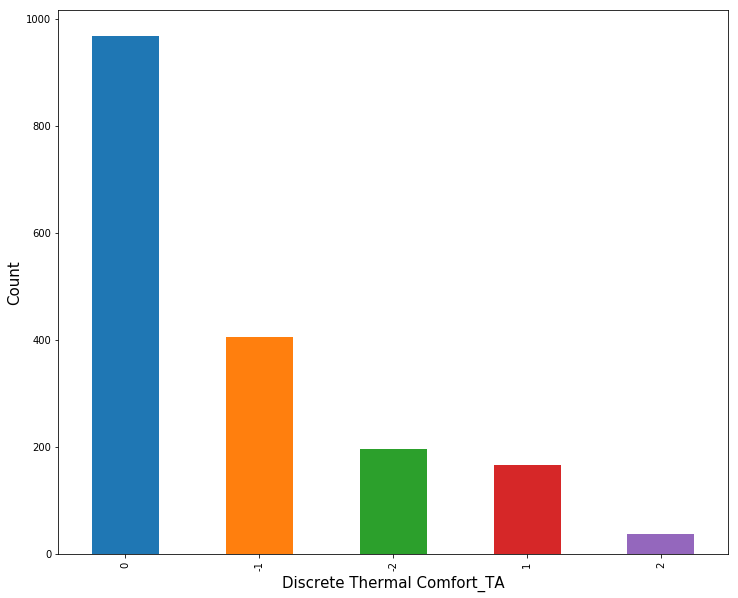

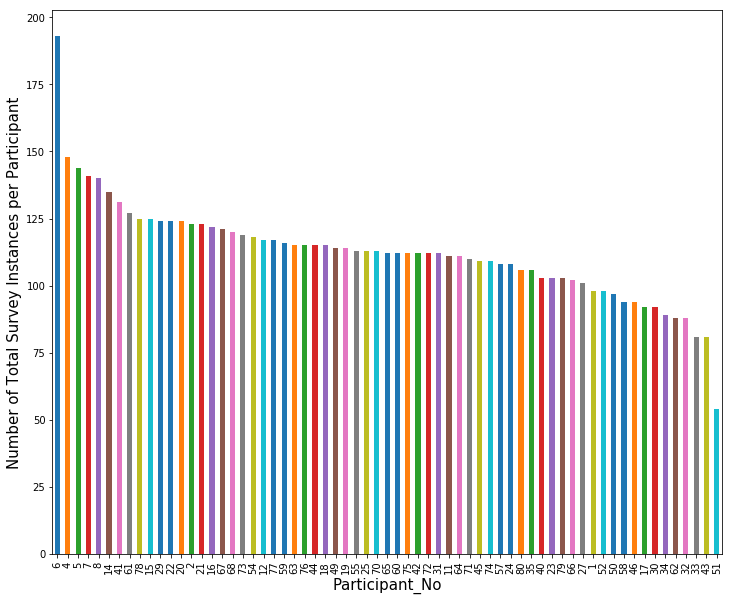

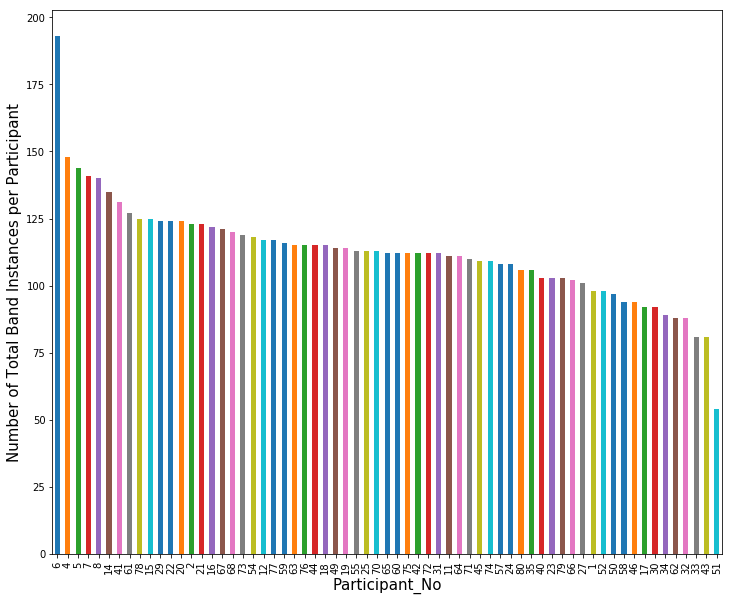

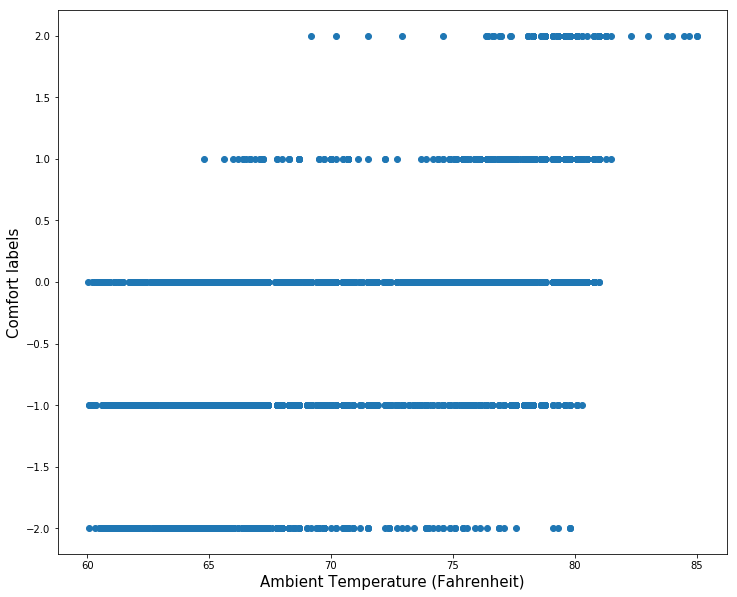

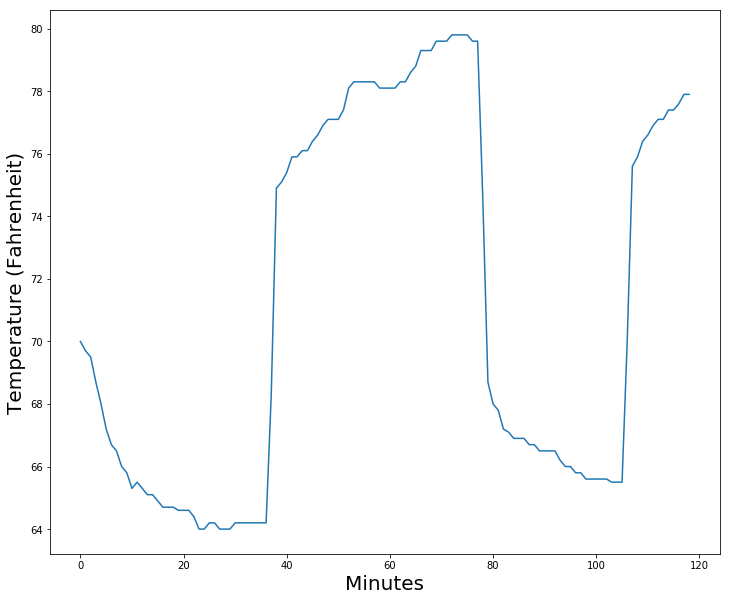

In [64]:
# number of participants in the dataset
num_participant = df['Participant_No'].nunique()

# list of participants id in the dataset
participants_list = df['Participant_No'].unique()

def c_to_f(x):
    x = x * 1.8 + 32
    return float(x)

def f_to_c(x):
    x = (x - 32) / 1.8
    return float(x)

df_with_celsius = df.copy()
df_with_celsius['Temperature_outside_c'] = df_with_celsius['Temperature_outside'].apply(f_to_c)
df_with_celsius['Temperature (C)'] = df_with_celsius['Temperature (Fahrenheit)'].apply(f_to_c)
df_with_celsius['SkinTemperature_c'] = df_with_celsius['SkinTemperature'].apply(f_to_c)


print("Number of participants: {}".format(num_participant))
# print("Number of Survey instances: {}".format(len(df_survey_feature_set1)))
# print("Number of Band instances: {}".format(len(df_band_feature_set1)))
print("Dataset description: \n{}".format(df_with_celsius[df_with_celsius['class'] == 'SurveyData'].describe(include = 'all')))

# Activity Histrogram
ax_activity = df['Activity'].value_counts().plot(kind = 'bar',figsize = (12,10))
ax_activity.set_xlabel("Activity", fontsize = 15)
ax_activity.set_ylabel("Instance Count", fontsize = 15)
plt.show()

# Gender Histogram
df_gender = df.groupby('Participant_No')['Gender'].unique()
print(df_gender.value_counts())
ax_gender = df_gender.value_counts().plot(kind = 'bar', figsize = (12,10))
ax_gender.set_xlabel("Gender", fontsize = 15)
ax_gender.set_ylabel("Count", fontsize = 15)
plt.show()

# Output labels (thermal comfort) histogram
df_survey = df[df['class'] == 'SurveyData']
print(df_survey['Discrete Thermal Comfort_TA'].value_counts())
ax_output = df_survey['Discrete Thermal Comfort_TA'].value_counts().plot(kind = 'bar', figsize = (12,10))
ax_output.set_xlabel("Discrete Thermal Comfort_TA", fontsize = 15)
ax_output.set_ylabel("Count", fontsize = 15)
plt.show()

# Histogram of instances per participant
ax_participant = df['Participant_No'].value_counts().plot(kind = 'bar', figsize = (12,10))
ax_participant.set_xlabel("Participant_No", fontsize = 15)
ax_participant.set_ylabel("Number of Total Survey Instances per Participant", fontsize = 15)
plt.show()

ax_participant = df['Participant_No'].value_counts().plot(kind = 'bar', figsize = (12,10))
ax_participant.set_xlabel("Participant_No", fontsize = 15)
ax_participant.set_ylabel("Number of Total Band Instances per Participant", fontsize = 15)
plt.show()

# Output labels (thermal comfort) temperature ranges
fig = plt.figure(figsize=(12, 10))
plt.scatter(df['Temperature (Fahrenheit)'], df['Discrete Thermal Comfort_TA'])
plt.ylabel('Comfort labels', fontsize = 15)
plt.xlabel('Ambient Temperature (Fahrenheit)', fontsize = 15)
plt.show()

# Temperature Schedule
# select only one participant
df_participant = df[df['Participant_No'] == 73].reset_index()

fig = plt.figure(figsize=(12, 10))
plt.plot(df_participant.index, df_participant['Temperature (Fahrenheit)'])
plt.ylabel('Temperature (Fahrenheit)', fontsize = 20)
plt.xlabel('Minutes', fontsize = 20)
plt.show()


# Linear Regression

In [11]:
df_lm = df_encoded.copy()

df_lm = df_lm[df_lm['class'] == 'SurveyData']
del df_lm['class']

# print(df_lm)
# randomize dataset
df_no_subjects_lm = df_lm.sample(frac = 1).reset_index(drop = True)

# since is one model for all participants, we don't need the 'Participant_No' feature
del df_no_subjects_lm['Participant_No']

X = np.array(df_no_subjects_lm.iloc[:, 0:len(list(df_no_subjects_lm)[:-1])])

# scale data
scaled_X = preprocessing.scale(X)

y = np.array(df_no_subjects_lm['Discrete Thermal Comfort_TA'])

lm = linear_model.LinearRegression()  
lm.fit(X, y) 
# lm.fit(scaled_X, y)

df_lm_coef = pd.DataFrame(list(zip(df_no_subjects_lm.columns, lm.coef_)), columns = ['features', 'estimatedCoefficients'])

# print df_lm_coef

df_lm_coef.sort_values(['estimatedCoefficients'], ascending=False)


,features,estimatedCoefficients
0,Temperature (Fahrenheit),8.450155e-02
9,Gender,1.456382e-02
1,MinuteCalories,1.288096e-02
7,Shoulder Circumference(cm),1.181029e-02
5,Activity,5.245373e-03
11,Humidity_outside,1.508877e-03
2,Gsr,5.293231e-07
3,SkinTemperature,-1.665718e-04
10,Temperature_outside,-1.196729e-03
8,Weight(lbs),-1.553537e-03


# Experiments

## One model for all participants, Multi-class classification problem

In [42]:
# Models in mind: Random Forest, KNN, SVM, Naive Bayes, and MLP

################################################ Feature set 1 ###############################################################
df_feature1_no_subjects = df_survey_feature_set1.copy()

# since is one model for all participants, we don't need the 'Participant_No' feature
del df_feature1_no_subjects['Participant_No']

# new set of features without the substracted features
feature_set1_no_subjects = list(df_feature1_no_subjects)[:-1]
num_feature_set1_no_subjects = len(feature_set1_no_subjects)
print("Feature Set 1 considers all features measured by the health band and phone survey")
print("Feature Set 1 (no subjects): {}".format(feature_set1_no_subjects))
print("Number of features in this set: {} \n".format(num_feature_set1_no_subjects))

################################################ Feature set 1_to ###############################################################
df_feature1_to_no_subjects = df_survey_feature_set1_to.copy()

# since is one model for all participants, we don't need the 'Participant_No' feature
del df_feature1_to_no_subjects['Participant_No']

# new set of features without the substracted features
feature_set1_to_no_subjects = list(df_feature1_to_no_subjects)[:-1]
num_feature_set1_to_no_subjects = len(feature_set1_to_no_subjects)
print("Feature Set 1 considers all features measured by the health band and phone survey")
print("Feature Set 1 (no subjects): {}".format(feature_set1_to_no_subjects))
print("Number of features in this set: {} \n".format(num_feature_set1_to_no_subjects))

################################################ Feature set 1_rh ###############################################################
df_feature1_rh_no_subjects = df_survey_feature_set1_rh.copy()

# since is one model for all participants, we don't need the 'Participant_No' feature
del df_feature1_rh_no_subjects['Participant_No']

# new set of features without the substracted features
feature_set1_rh_no_subjects = list(df_feature1_rh_no_subjects)[:-1]
num_feature_set1_rh_no_subjects = len(feature_set1_rh_no_subjects)
print("Feature Set 1 considers all features measured by the health band and phone survey")
print("Feature Set 1 (no subjects): {}".format(feature_set1_rh_no_subjects))
print("Number of features in this set: {} \n".format(num_feature_set1_rh_no_subjects))


################################################ Feature set 2 ###############################################################
df_feature2_no_subjects = df_survey_feature_set2.copy()

# since is one model for all participants, we don't need the 'Participant_No' feature
del df_feature2_no_subjects['Participant_No']

# new set of features without the substracted features
feature_set2_no_subjects = list(df_feature2_no_subjects)[:-1]
num_feature_set2_no_subjects = len(feature_set2_no_subjects)
print("Feature Set 2 only takes into account the features that FORK can potentially extract from people")
print("Feature Set 2 (no subjects): {}".format(feature_set2_no_subjects))
print("Number of features in this set: {} \n".format(num_feature_set2_no_subjects))

################################################ Feature set 2_to ###############################################################
df_feature2_to_no_subjects = df_survey_feature_set2_to.copy()

# since is one model for all participants, we don't need the 'Participant_No' feature
del df_feature2_to_no_subjects['Participant_No']

# new set of features without the substracted features
feature_set2_to_no_subjects = list(df_feature2_to_no_subjects)[:-1]
num_feature_set2_to_no_subjects = len(df_feature2_to_no_subjects)
print("Feature Set 2 only takes into account the features that FORK can potentially extract from people")
print("Feature Set 2 (no subjects): {}".format(feature_set2_to_no_subjects))
print("Number of features in this set: {} \n".format(num_feature_set2_to_no_subjects))

################################################ Feature set 2_rh ###############################################################
df_feature2_rh_no_subjects = df_survey_feature_set2_rh.copy()

# since is one model for all participants, we don't need the 'Participant_No' feature
del df_feature2_rh_no_subjects['Participant_No']

# new set of features without the substracted features
feature_set2_rh_no_subjects = list(df_feature2_rh_no_subjects)[:-1]
num_feature_set2_rh_no_subjects = len(feature_set2_rh_no_subjects)
print("Feature Set 2 only takes into account the features that FORK can potentially extract from people")
print("Feature Set 2 (no subjects): {}".format(feature_set2_rh_no_subjects))
print("Number of features in this set: {} \n".format(num_feature_set2_rh_no_subjects))

################################################ Feature set 3 ###############################################################

df_feature3_no_subjects = df_survey_feature_set3.copy()
# we only care about Temperature and label

# since is one model for all participants, we don't need the 'Participant_No' feature
del df_feature3_no_subjects['Participant_No']

# new set of features without the substracted features
feature_set3_no_subjects = list(df_feature3_no_subjects)[:-1]
num_feature_set3_no_subjects = len(feature_set3_no_subjects)

print("Feature Set 3 only uses actual environmental features")
print("Feature Set 3 (no subjects): {}".format(feature_set3_no_subjects))
print("Number of features in this set: {}\n".format(num_feature_set3_no_subjects))

################################################ Feature set 3b ###############################################################

df_feature3b_no_subjects = df_survey_feature_set3b.copy()
# we only care about Temperature and label

# since is one model for all participants, we don't need the 'Participant_No' feature
del df_feature3b_no_subjects['Participant_No']

# new set of features without the substracted features
feature_set3b_no_subjects = list(df_feature3b_no_subjects)[:-1]
num_feature_set3b_no_subjects = len(feature_set3b_no_subjects)

print("Feature Set 3 only uses actual room temperature")
print("Feature Set 3 (no subjects): {}".format(feature_set3b_no_subjects))
print("Number of features in this set: ", num_feature_set3b_no_subjects)


Feature Set 1 considers all features measured by the health band and phone survey
Feature Set 1 (no subjects): ['Temperature (Fahrenheit)', 'SkinTemperature', 'ClothingInsulation', 'Height(cm)', 'Shoulder Circumference(cm)', 'Weight(lbs)', 'Gender', 'Temperature_outside', 'Humidity_outside']
Number of features in this set: 9 

Feature Set 1 considers all features measured by the health band and phone survey
Feature Set 1 (no subjects): ['Temperature (Fahrenheit)', 'SkinTemperature', 'ClothingInsulation', 'Height(cm)', 'Shoulder Circumference(cm)', 'Weight(lbs)', 'Gender', 'Temperature_outside']
Number of features in this set: 8 

Feature Set 1 considers all features measured by the health band and phone survey
Feature Set 1 (no subjects): ['Temperature (Fahrenheit)', 'SkinTemperature', 'ClothingInsulation', 'Height(cm)', 'Shoulder Circumference(cm)', 'Weight(lbs)', 'Gender', 'Humidity_outside']
Number of features in this set: 8 

Feature Set 2 only takes into account the features that 

### Random Forest

Number of folds: 10


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 1000}


No handles with labels found to put in legend.


The optimal depth is:  14 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7109132855975602 



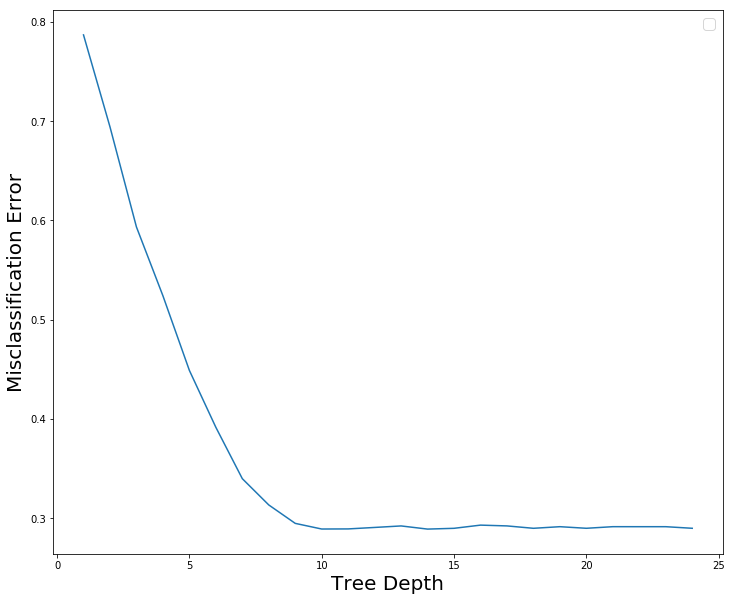

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=14, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)

Accuracy (f1 micro) on test set: 0.74
F1 micro on test set: 0.74
F1 macro on test set: 0.66

Confusion Matrix: 
[[ 37  21   1   0   0]
 [ 14  76  29   2   1]
 [  0  30 246  14   0]
 [  1   1  20  26   1]
 [  0   0   1   4   6]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.71      0.63      0.67        59
          -1       0.59      0.62      0.61       122
           0       0.83      0.85      0.84       290
           1       0.57      0.53      0.55        49
           2       0.75      0.55  

/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


No handles with labels found to put in legend.


The optimal depth is:  21 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7076134247364474 



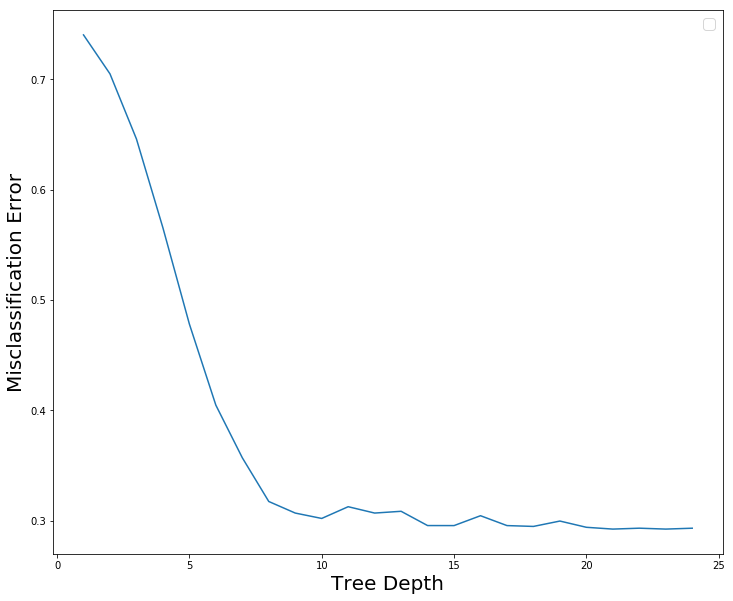

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=21, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)

Accuracy (f1 micro) on test set: 0.73
F1 micro on test set: 0.73
F1 macro on test set: 0.66

Confusion Matrix: 
[[ 39  19   1   0   0]
 [ 15  72  33   1   1]
 [  0  31 248  11   0]
 [  1   2  23  23   0]
 [  0   0   1   4   6]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.71      0.66      0.68        59
          -1       0.58      0.59      0.59       122
           0       0.81      0.86      0.83       290
           1       0.59      0.47      0.52        49
           2       0.86      0.55      0.67

/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 100}


No handles with labels found to put in legend.


The optimal depth is:  23 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7117136107141145 



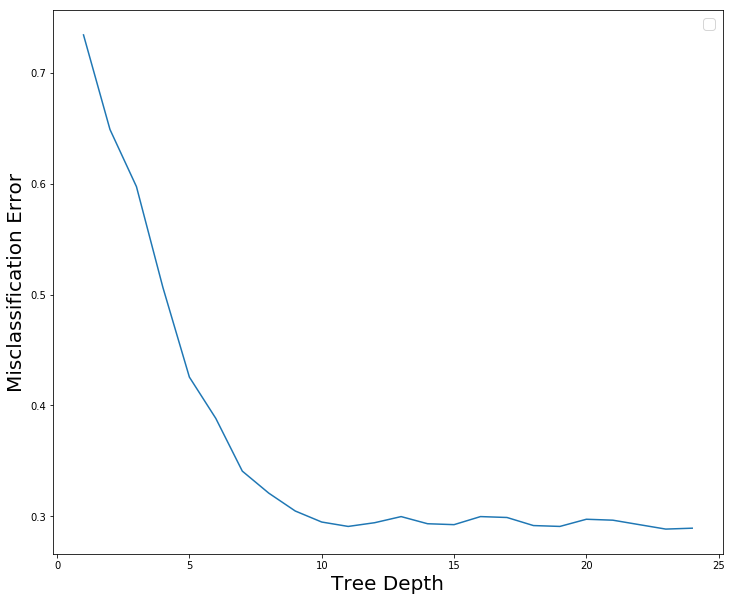

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=23, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)

Accuracy (f1 micro) on test set: 0.73
F1 micro on test set: 0.73
F1 macro on test set: 0.67

Confusion Matrix: 
[[ 38  20   1   0   0]
 [ 14  75  30   2   1]
 [  0  30 245  15   0]
 [  1   1  24  23   0]
 [  0   0   1   3   7]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.72      0.64      0.68        59
          -1       0.60      0.61      0.60       122
           0       0.81      0.84      0.83       290
           1       0.53      0.47      0.50        49
           2       0.88      0.64      0.74   

/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 100}


No handles with labels found to put in legend.


The optimal depth is:  23 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7148867240904564 



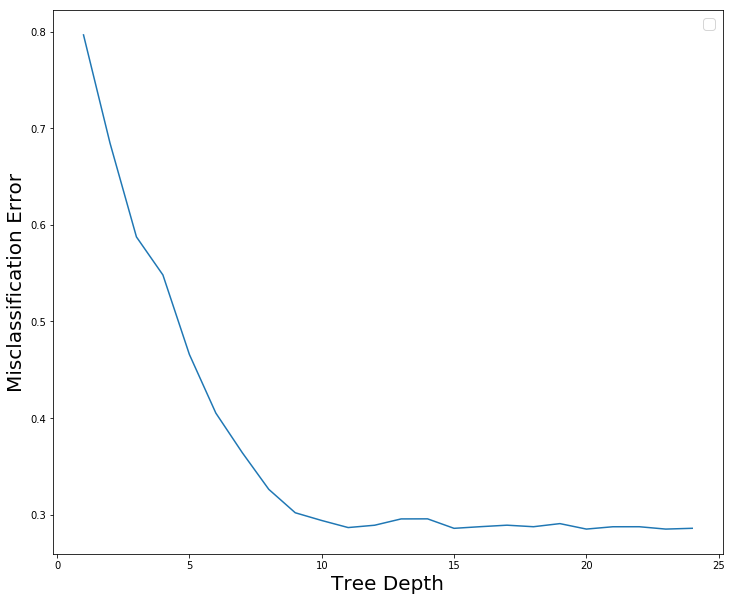

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=23, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)

Accuracy (f1 micro) on test set: 0.71
F1 micro on test set: 0.71
F1 macro on test set: 0.64

Confusion Matrix: 
[[ 34  23   2   0   0]
 [ 14  72  34   2   0]
 [  2  35 241  12   0]
 [  1   1  19  26   2]
 [  0   0   2   3   6]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.67      0.58      0.62        59
          -1       0.55      0.59      0.57       122
           0       0.81      0.83      0.82       290
           1       0.60      0.53      0.57        49
           2       0.75      0.55   

No handles with labels found to put in legend.


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  1.0 



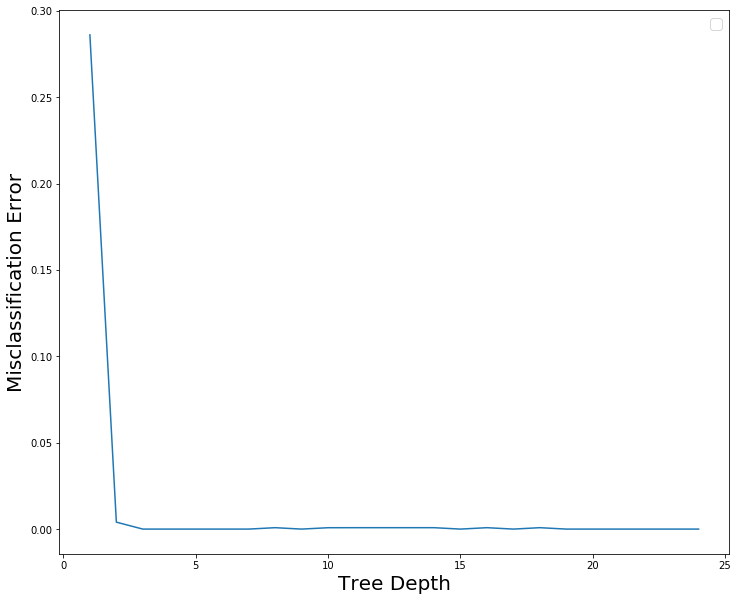

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)

Accuracy (f1 micro) on test set: 1.0
F1 micro on test set: 1.0
F1 macro on test set: 0.99

Confusion Matrix: 
[[ 59   0   0   0   0]
 [  0 122   0   0   0]
 [  0   0 290   0   0]
 [  0   0   0  49   0]
 [  0   0   0   1  10]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       1.00      1.00      1.00        59
          -1       1.00      1.00      1.00       122
           0       1.00      1.00      1.00       290
           1       0.98      1.00      0.99        49
           2       1.00      0.91      0.95   

/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 1000}


No handles with labels found to put in legend.


The optimal depth is:  13 

Expected accuracy (f1 micro) based on Cross-Validation:  0.6890158249849148 



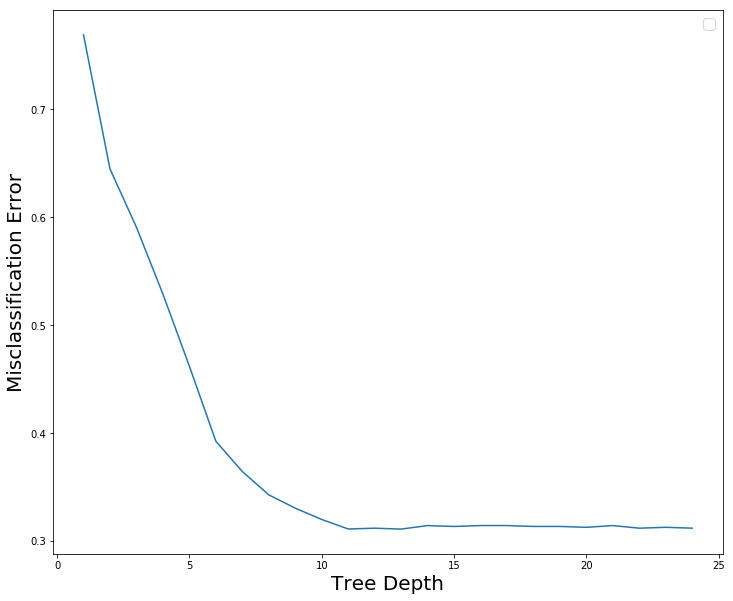

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=13, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)

Accuracy (f1 micro) on test set: 0.69
F1 micro on test set: 0.69
F1 macro on test set: 0.62

Confusion Matrix: 
[[ 31  25   3   0   0]
 [ 15  69  36   2   0]
 [  1  39 237  13   0]
 [  1   2  19  25   2]
 [  0   0   0   5   6]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.65      0.53      0.58        59
          -1       0.51      0.57      0.54       122
           0       0.80      0.82      0.81       290
           1       0.56      0.51      0.53        49
           2       0.75      0.55      0.6

/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


No handles with labels found to put in legend.


The optimal depth is:  23 

Expected accuracy (f1 micro) based on Cross-Validation:  0.6877690640372222 



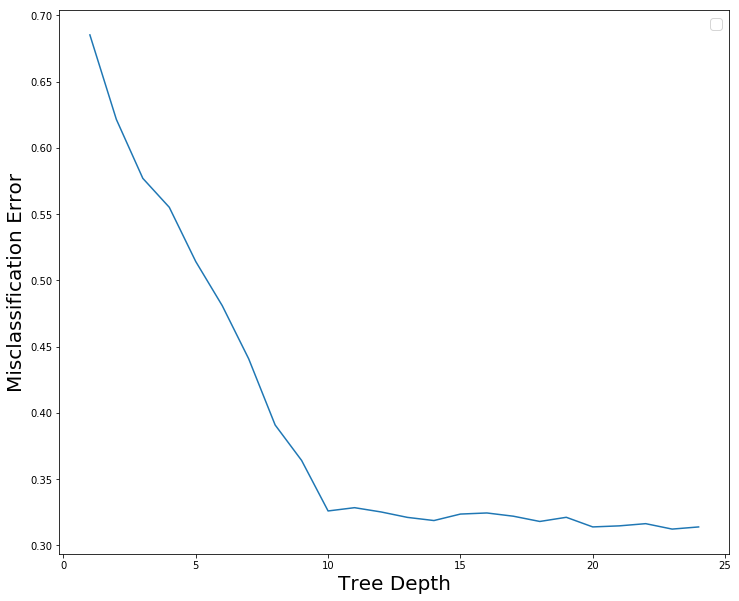

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=23, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)

Accuracy (f1 micro) on test set: 0.72
F1 micro on test set: 0.72
F1 macro on test set: 0.63

Confusion Matrix: 
[[ 27  23   9   0   0]
 [  8  74  39   1   0]
 [  0  29 252   9   0]
 [  1   0  26  21   1]
 [  0   0   2   3   6]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.75      0.46      0.57        59
          -1       0.59      0.61      0.60       122
           0       0.77      0.87      0.82       290
           1       0.62      0.43      0.51        49
           2       0.86      0.55      0.67

/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


No handles with labels found to put in legend.


The optimal depth is:  11 

Expected accuracy (f1 micro) based on Cross-Validation:  0.39535232220907324 



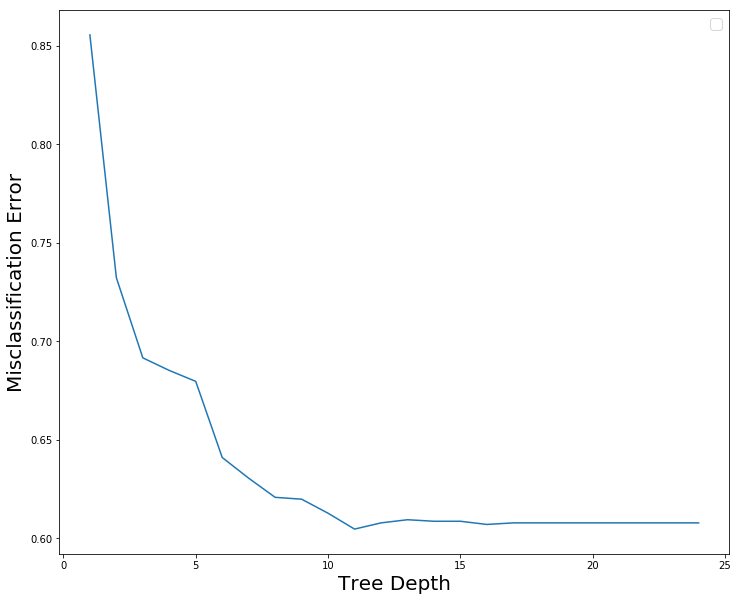

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=11, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)

Accuracy (f1 micro) on test set: 0.38
F1 micro on test set: 0.38
F1 macro on test set: 0.32

Confusion Matrix: 
[[24 29  6  0  0]
 [35 58 25  4  0]
 [40 48 93 80 29]
 [ 0  1 17 22  9]
 [ 0  0  3  4  4]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.24      0.41      0.30        59
          -1       0.43      0.48      0.45       122
           0       0.65      0.32      0.43       290
           1       0.20      0.45      0.28        49
           2       0.10      0.36      0.15        11

   micro avg  

In [57]:
rf_acc_1 = learnRF(df_feature1_no_subjects, num_feature_set1_no_subjects) # featureset1
rf_acc_1_to = learnRF(df_feature1_to_no_subjects, num_feature_set1_to_no_subjects) # featureset1_to
rf_acc_1_rh = learnRF(df_feature1_rh_no_subjects, num_feature_set1_rh_no_subjects) # featureset1_rh

rf_acc_2 = learnRF(df_feature2_no_subjects, num_feature_set2_no_subjects) # featureset2
rf_acc_2_to = learnRF(df_feature2_to_no_subjects, num_feature_set2_to_no_subjects) # featureset2
rf_acc_2_rh = learnRF(df_feature2_rh_no_subjects, num_feature_set2_rh_no_subjects) # featureset2

rf_acc_3 = learnRF(df_feature3_no_subjects, num_feature_set3_no_subjects) # featureset3
rf_acc_3_b = learnRF(df_feature3b_no_subjects, num_feature_set3b_no_subjects) # featureset3b


### KNN

In [44]:
knn_acc_1 = learnKNN(df_feature1_no_subjects, num_feature_set1_no_subjects) # featureset1
knn_acc_1_to = learnKNN(df_feature1_to_no_subjects, num_feature_set1_to_no_subjects) # featureset1_to
knn_acc_1_rh = learnKNN(df_feature1_rh_no_subjects, num_feature_set1_rh_no_subjects) # featureset1_rh

knn_acc_2 = learnKNN(df_feature2_no_subjects, num_feature_set2_no_subjects) # featureset2
knn_acc_2_to = learnKNN(df_feature2_to_no_subjects, num_feature_set2_to_no_subjects) # featureset2
knn_acc_2_rh = learnKNN(df_feature2_rh_no_subjects, num_feature_set2_rh_no_subjects) # featureset2

knn_acc_3 = learnKNN(df_feature3_no_subjects, num_feature_set3_no_subjects) # featureset3
knn_acc_3_b = learnKNN(df_feature3b_no_subjects, num_feature_set3b_no_subjects) # featureset3b


Number of folds: 10


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'algorithm': 'brute', 'metric': 'seuclidean', 'n_neighbors': 3, 'weights': 'distance'}


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='seuclidean',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='distance')

Accuracy (f1 micro) on test set: 0.72
F1 micro on test set: 0.72
F1 macro on test set: 0.64

Confusion Matrix: 
[[ 43  16   0   0   0]
 [ 21  67  31   2   1]
 [  3  36 240  11   0]
 [  2   2  17  26   2]
 [  0   0   2   3   6]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.62      0.73      0.67        59
          -1       0.55      0.55      0.55       122
           0       0.83      0.83      0.83       290
           1       0.62      0.53      0.57        49
           2       0.67      0.55      0.60        11

   micro avg       0.72      0.72      0.72       531
   macro avg       0.66      0.64      0.64       531
weigh

/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'algorithm': 'brute', 'metric': 'seuclidean', 'n_neighbors': 9, 'weights': 'distance'}


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='seuclidean',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='distance')

Accuracy (f1 micro) on test set: 0.7
F1 micro on test set: 0.7
F1 macro on test set: 0.62

Confusion Matrix: 
[[ 42  17   0   0   0]
 [ 20  64  36   1   1]
 [  4  36 236  12   2]
 [  0   3  24  22   0]
 [  0   0   2   3   6]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.64      0.71      0.67        59
          -1       0.53      0.52      0.53       122
           0       0.79      0.81      0.80       290
           1       0.58      0.45      0.51        49
           2       0.67      0.55      0.60        11

   micro avg       0.70      0.70      0.70       531
   macro avg       0.64      0.61      0.62       531
weighte

/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'algorithm': 'brute', 'metric': 'seuclidean', 'n_neighbors': 3, 'weights': 'distance'}


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='seuclidean',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='distance')

Accuracy (f1 micro) on test set: 0.71
F1 micro on test set: 0.71
F1 macro on test set: 0.64

Confusion Matrix: 
[[ 43  16   0   0   0]
 [ 19  67  33   2   1]
 [  2  39 233  15   1]
 [  2   2  18  25   2]
 [  0   0   1   3   7]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.65      0.73      0.69        59
          -1       0.54      0.55      0.54       122
           0       0.82      0.80      0.81       290
           1       0.56      0.51      0.53        49
           2       0.64      0.64      0.64        11

   micro avg       0.71      0.71      0.71       531
   macro avg       0.64      0.65      0.64       531
weigh

/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'algorithm': 'brute', 'metric': 'seuclidean', 'n_neighbors': 13, 'weights': 'distance'}


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='seuclidean',
           metric_params=None, n_jobs=None, n_neighbors=13, p=2,
           weights='distance')

Accuracy (f1 micro) on test set: 0.68
F1 micro on test set: 0.68
F1 macro on test set: 0.59

Confusion Matrix: 
[[ 32  24   3   0   0]
 [ 16  64  39   3   0]
 [  0  44 234  12   0]
 [  1   2  18  27   1]
 [  0   0   1   6   4]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.65      0.54      0.59        59
          -1       0.48      0.52      0.50       122
           0       0.79      0.81      0.80       290
           1       0.56      0.55      0.56        49
           2       0.80      0.36      0.50        11

   micro avg       0.68      0.68      0.68       531
   macro avg       0.66      0.56      0.59       531
wei

/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'algorithm': 'brute', 'metric': 'seuclidean', 'n_neighbors': 7, 'weights': 'distance'}


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='seuclidean',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='distance')

Accuracy (f1 micro) on test set: 0.67
F1 micro on test set: 0.67
F1 macro on test set: 0.57

Confusion Matrix: 
[[ 31  24   4   0   0]
 [ 18  61  40   2   1]
 [  3  42 234  11   0]
 [  0   3  17  27   2]
 [  0   0   1   6   4]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.60      0.53      0.56        59
          -1       0.47      0.50      0.48       122
           0       0.79      0.81      0.80       290
           1       0.59      0.55      0.57        49
           2       0.57      0.36      0.44        11

   micro avg       0.67      0.67      0.67       531
   macro avg       0.60      0.55      0.57       531
weigh

/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'algorithm': 'brute', 'metric': 'seuclidean', 'n_neighbors': 11, 'weights': 'distance'}


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='seuclidean',
           metric_params=None, n_jobs=None, n_neighbors=11, p=2,
           weights='distance')

Accuracy (f1 micro) on test set: 0.66
F1 micro on test set: 0.66
F1 macro on test set: 0.56

Confusion Matrix: 
[[ 32  19   8   0   0]
 [  8  63  48   3   0]
 [  0  40 233  13   4]
 [  0   2  25  21   1]
 [  0   0   3   4   4]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.80      0.54      0.65        59
          -1       0.51      0.52      0.51       122
           0       0.74      0.80      0.77       290
           1       0.51      0.43      0.47        49
           2       0.44      0.36      0.40        11

   micro avg       0.66      0.66      0.66       531
   macro avg       0.60      0.53      0.56       531
wei

/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### SVM

In [45]:
svm_acc_1 = learnSVM(df_feature1_no_subjects, num_feature_set1_no_subjects) # featureset1
svm_acc_1_to = learnSVM(df_feature1_to_no_subjects, num_feature_set1_to_no_subjects) # featureset1
svm_acc_1_rh = learnSVM(df_feature1_rh_no_subjects, num_feature_set1_rh_no_subjects) # featureset1

svm_acc_2 = learnSVM(df_feature2_no_subjects, num_feature_set2_no_subjects) # featureset2
svm_acc_2_to = learnSVM(df_feature2_to_no_subjects, num_feature_set2_to_no_subjects) # featureset2
svm_acc_2_rh = learnSVM(df_feature2_rh_no_subjects, num_feature_set2_rh_no_subjects) # featureset2

svm_acc_3 = learnSVM(df_feature3_no_subjects, num_feature_set3_no_subjects) # featureset3
svm_acc_3_b = learnSVM(df_feature3b_no_subjects, num_feature_set3b_no_subjects) # featureset3b
    

Number of folds: 10


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'C': 1000, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=100, shrinking=True,
  tol=0.001, verbose=False)

Accuracy (f1 micro) on test set: 0.67
F1 micro on test set: 0.67
F1 macro on test set: 0.62

Confusion Matrix: 
[[ 40  18   1   0   0]
 [ 23  73  22   3   1]
 [  6  57 208  19   0]
 [  3   3  12  29   2]
 [  0   0   2   3   6]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.56      0.68      0.61        59
          -1       0.48      0.60      0.53       122
           0       0.85      0.72      0.78       290
           1       0.54      0.59      0.56        49
           2       0.67      0.55      0.60        11

   micro avg       0.67      0.67      0.67       531
   macro avg      

/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'C': 1000, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=100, shrinking=True,
  tol=0.001, verbose=False)

Accuracy (f1 micro) on test set: 0.64
F1 micro on test set: 0.64
F1 macro on test set: 0.57

Confusion Matrix: 
[[ 40  18   1   0   0]
 [ 26  74  17   4   1]
 [  6  58 194  25   7]
 [  1   6  12  28   2]
 [  0   0   2   3   6]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.55      0.68      0.61        59
          -1       0.47      0.61      0.53       122
           0       0.86      0.67      0.75       290
           1       0.47      0.57      0.51        49
           2       0.38      0.55      0.44        11

   micro avg       0.64      0.64      0.64       531
   macro avg      

/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'C': 1000, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=100, shrinking=True,
  tol=0.001, verbose=False)

Accuracy (f1 micro) on test set: 0.68
F1 micro on test set: 0.68
F1 macro on test set: 0.62

Confusion Matrix: 
[[ 42  16   1   0   0]
 [ 22  75  21   3   1]
 [  6  57 205  20   2]
 [  1   3  13  31   1]
 [  0   0   1   4   6]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.59      0.71      0.65        59
          -1       0.50      0.61      0.55       122
           0       0.85      0.71      0.77       290
           1       0.53      0.63      0.58        49
           2       0.60      0.55      0.57        11

   micro avg       0.68      0.68      0.68       531
   macro avg      

/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'C': 1000, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=100, shrinking=True,
  tol=0.001, verbose=False)

Accuracy (f1 micro) on test set: 0.62
F1 micro on test set: 0.62
F1 macro on test set: 0.54

Confusion Matrix: 
[[ 39  20   0   0   0]
 [ 35  68  16   3   0]
 [ 14  56 190  27   3]
 [  3   6   7  25   8]
 [  0   0   1   3   7]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.43      0.66      0.52        59
          -1       0.45      0.56      0.50       122
           0       0.89      0.66      0.75       290
           1       0.43      0.51      0.47        49
           2       0.39      0.64      0.48        11

   micro avg       0.62      0.62      0.62       531
   macro avg      

/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}


SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=100,
  shrinking=True, tol=0.001, verbose=False)

Accuracy (f1 micro) on test set: 1.0
F1 micro on test set: 1.0
F1 macro on test set: 1.0

Confusion Matrix: 
[[ 59   0   0   0   0]
 [  0 122   0   0   0]
 [  0   0 290   0   0]
 [  0   0   0  49   0]
 [  0   0   0   0  11]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       1.00      1.00      1.00        59
          -1       1.00      1.00      1.00       122
           0       1.00      1.00      1.00       290
           1       1.00      1.00      1.00        49
           2       1.00      1.00      1.00        11

   micro avg       1.00      1.00      1.00       531
   macro avg       1.

/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'C': 1000, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=100, shrinking=True,
  tol=0.001, verbose=False)

Accuracy (f1 micro) on test set: 0.53
F1 micro on test set: 0.53
F1 macro on test set: 0.5

Confusion Matrix: 
[[ 45  14   0   0   0]
 [ 54  51  13   4   0]
 [ 25  62 149  51   3]
 [  5   0   8  28   8]
 [  0   0   0   3   8]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.35      0.76      0.48        59
          -1       0.40      0.42      0.41       122
           0       0.88      0.51      0.65       290
           1       0.33      0.57      0.41        49
           2       0.42      0.73      0.53        11

   micro avg       0.53      0.53      0.53       531
   macro avg       

/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'C': 1000, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=100, shrinking=True,
  tol=0.001, verbose=False)

Accuracy (f1 micro) on test set: 0.47
F1 micro on test set: 0.47
F1 macro on test set: 0.44

Confusion Matrix: 
[[36 22  1  0  0]
 [31 82  7  1  1]
 [25 82 96 69 18]
 [ 0  5  6 31  7]
 [ 0  0  0  4  7]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.39      0.61      0.48        59
          -1       0.43      0.67      0.52       122
           0       0.87      0.33      0.48       290
           1       0.30      0.63      0.40        49
           2       0.21      0.64      0.32        11

   micro avg       0.47      0.47      0.47       531
   macro avg       0.44      0.58      0.44

/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Naive Bayes

In [46]:
nb_acc_1 = learnNB(df_feature1_no_subjects, num_feature_set1_no_subjects)
nb_acc_1_to = learnNB(df_feature1_to_no_subjects, num_feature_set1_to_no_subjects)
nb_acc_1_rh = learnNB(df_feature1_rh_no_subjects, num_feature_set1_rh_no_subjects)

nb_acc_2 = learnNB(df_feature2_no_subjects, num_feature_set2_no_subjects)
nb_acc_2_to = learnNB(df_feature2_to_no_subjects, num_feature_set2_to_no_subjects)
nb_acc_2_rh = learnNB(df_feature2_rh_no_subjects, num_feature_set2_rh_no_subjects)

nb_acc_3 = learnNB(df_feature3_no_subjects, num_feature_set3_no_subjects)
nb_acc_3_b = learnNB(df_feature3b_no_subjects, num_feature_set3b_no_subjects)


Expected accuracy (f1 micro) based on Cross-Validation: 0.4883130035371649


GaussianNB(priors=None, var_smoothing=1e-09)

Accuracy (f1 micro) on test set: 0.54
F1 micro on test set: 0.54
F1 macro on test set: 0.45

Confusion Matrix: 
[[ 24  22  13   0   0]
 [ 19  58  42   3   0]
 [ 10  51 179  34  16]
 [  0   2  20  19   8]
 [  0   0   3   1   7]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.45      0.41      0.43        59
          -1       0.44      0.48      0.45       122
           0       0.70      0.62      0.65       290
           1       0.33      0.39      0.36        49
           2       0.23      0.64      0.33        11

   micro avg       0.54      0.54      0.54       531
   macro avg       0.43      0.50      0.45       531
weighted avg       0.57      0.54      0.55       531

Expected accuracy (f1 micro) based on Cross-Validation: 0.4689529770853504


GaussianNB(priors=None, var_smoothing=1e-09)

Accuracy (f

/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predic

### MLP

In [47]:
mlp_acc_1 = learnMLP(df_feature1_no_subjects, num_feature_set1_no_subjects)
mlp_acc_1_to = learnMLP(df_feature1_to_no_subjects, num_feature_set1_to_no_subjects)
mlp_acc_1_rh = learnMLP(df_feature1_rh_no_subjects, num_feature_set1_rh_no_subjects)

mlp_acc_2 = learnMLP(df_feature2_no_subjects, num_feature_set2_no_subjects)
mlp_acc_2_to = learnMLP(df_feature2_to_no_subjects, num_feature_set2_to_no_subjects)
mlp_acc_2_rh = learnMLP(df_feature2_rh_no_subjects, num_feature_set2_rh_no_subjects)

mlp_acc_3 = learnMLP(df_feature3_no_subjects, num_feature_set3_no_subjects)
mlp_acc_3_b = learnMLP(df_feature3b_no_subjects, num_feature_set3b_no_subjects)


MLPClassifier(activation='tanh', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(11,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=300, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=100, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

Expected accuracy (f1 micro) based on Cross-Validation:  0.6159313550690644 


Accuracy (f1 micro) on test set: 0.66
F1 micro on test set: 0.66
F1 macro on test set: 0.56

Confusion Matrix: 
[[ 28  25   6   0   0]
 [ 19  62  40   1   0]
 [  3  31 239  13   4]
 [  0   2  31  14   2]
 [  0   0   1   2   8]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.56      0.47      0.51        59
          -1       0.52      0.51      0.51       122
           0       0.75      0.82      0.79       2


Expected accuracy (f1 micro) based on Cross-Validation:  0.5626869847278448 


Accuracy (f1 micro) on test set: 0.57
F1 micro on test set: 0.57
F1 macro on test set: 0.38

Confusion Matrix: 
[[ 12  25  22   0   0]
 [  7  58  57   0   0]
 [  3  56 231   0   0]
 [  0   0  48   1   0]
 [  0   0   8   0   3]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.55      0.20      0.30        59
          -1       0.42      0.48      0.44       122
           0       0.63      0.80      0.70       290
           1       1.00      0.02      0.04        49
           2       1.00      0.27      0.43        11

   micro avg       0.57      0.57      0.57       531
   macro avg       0.72      0.35      0.38       531
weighted avg       0.61      0.57      0.53       531



### Result Plots


Accuracy (f1 micro) on test set: 0.55
F1 micro on test set: 0.55
F1 macro on test set: 0.14

Confusion Matrix: 
[[  0   0  59   0   0]
 [  0   0 122   0   0]
 [  0   0 290   0   0]
 [  0   0  49   0   0]
 [  0   0  11   0   0]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        59
          -1       0.00      0.00      0.00       122
           0       0.55      1.00      0.71       290
           1       0.00      0.00      0.00        49
           2       0.00      0.00      0.00        11

   micro avg       0.55      0.55      0.55       531
   macro avg       0.11      0.20      0.14       531
weighted avg       0.30      0.55      0.39       531

Metric: F1-score micro
Data Split: 30% Test, 70% Train


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predic

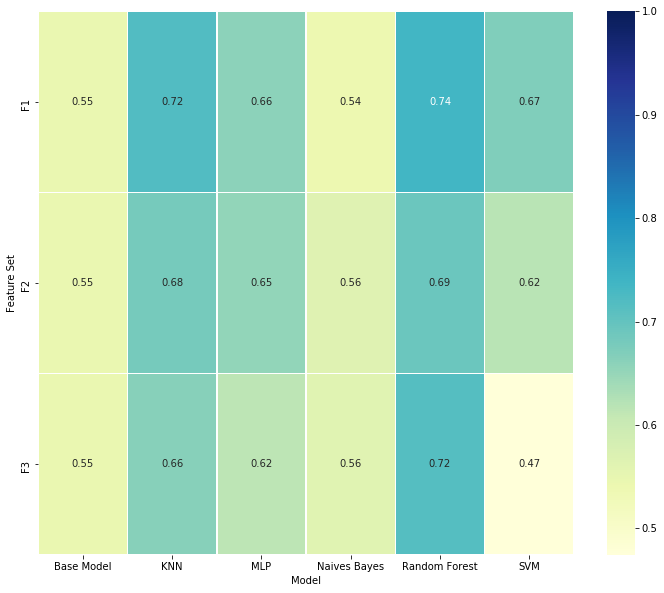

Target Labels:  [ 0 -1 -2  1  2]
Feature Set 1:  ['Temperature (Fahrenheit)', 'SkinTemperature', 'ClothingInsulation', 'Height(cm)', 'Shoulder Circumference(cm)', 'Weight(lbs)', 'Gender', 'Temperature_outside', 'Humidity_outside']
Feature Set 2:  ['Temperature (Fahrenheit)', 'Height(cm)', 'Shoulder Circumference(cm)', 'Temperature_outside', 'Humidity_outside']
Feature Set 3:  ['Temperature (Fahrenheit)', 'Temperature_outside', 'Humidity_outside']


In [48]:
# comparing base model
test_size_percentage = 0.3 # if changed, change in all places
base_model_pred = np.zeros(int(round(len(df_feature1_no_subjects) * test_size_percentage))) # comfort label is 0 in the dataset

X = np.array(df_feature1_no_subjects.iloc[:, 0:num_feature_set1_no_subjects])
y = np.array(df_feature1_no_subjects['Discrete Thermal Comfort_TA'])
# split into train and test
test_size_percentage = 0.3 

# X_train = train + cv set (train_vectors)
# X_test = test set (test_vectors)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size_percentage, 
                                                        random_state = 100, stratify = y)
base_model_acc = getClfMetrics(y_test, base_model_pred)

experiment_acc_both_features = pd.DataFrame([['Random Forest', 'F1', rf_acc_1], 
                                ['KNN', 'F1', knn_acc_1],
                                ['SVM', 'F1', svm_acc_1],
                                ['Naives Bayes', 'F1', nb_acc_1],
                                ['MLP', 'F1', mlp_acc_1],
                                ['Random Forest', 'F2', rf_acc_2], 
                                ['KNN', 'F2', knn_acc_2],
                                ['SVM', 'F2', svm_acc_2],
                                ['Naives Bayes', 'F2', nb_acc_2],
                                ['MLP', 'F2', mlp_acc_2],
                                ['Random Forest', 'F3', rf_acc_3], 
                                ['KNN', 'F3', knn_acc_3],
                                ['SVM', 'F3', svm_acc_3],
                                ['Naives Bayes', 'F3', nb_acc_3],
                                ['MLP', 'F3', mlp_acc_3],
                                ['Base Model', 'F1', base_model_acc],
                                ['Base Model', 'F2', base_model_acc],
                                ['Base Model', 'F3', base_model_acc]],
                          columns = ['Model', 'Feature Set', 'Accuracy'])

# plot heatmap
print("Metric: F1-score micro")
print("Data Split: 30% Test, 70% Train")
experiment_acc_both_features = experiment_acc_both_features.pivot("Feature Set", "Model", "Accuracy")
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(experiment_acc_both_features, linewidths = 0.5, annot = True, vmax = 1, cmap = "YlGnBu")
plt.show()

print("Target Labels: ", df_feature1_no_subjects['Discrete Thermal Comfort_TA'].unique())
print("Feature Set 1: ", feature_set1_no_subjects)
print("Feature Set 2: ", feature_set2_no_subjects)
print("Feature Set 3: ", feature_set3_no_subjects)


## One model for all participants, Binary classification problem

In [50]:
# Models in mind: Random Forest, KNN, SM, Naive Bayes, and MLP
df_feature1_binary = df_survey_feature_set1.copy()
df_feature1_to_binary = df_survey_feature_set1_to.copy()
df_feature1_rh_binary = df_survey_feature_set1_rh.copy()

df_feature2_binary = df_survey_feature_set2.copy()
df_feature2_to_binary = df_survey_feature_set2_to.copy()
df_feature2_rh_binary = df_survey_feature_set2_rh.copy()


df_feature3_binary = df_survey_feature_set3.copy()
df_feature3b_binary = df_survey_feature_set3b.copy()

df_feature1_binary['Discomfort'] = df_feature1_binary['Discrete Thermal Comfort_TA'].map(lambda x: 1 if x != 0 else 0)
df_feature1_to_binary['Discomfort'] = df_feature1_to_binary['Discrete Thermal Comfort_TA'].map(lambda x: 1 if x != 0 else 0)
df_feature1_rh_binary['Discomfort'] = df_feature1_rh_binary['Discrete Thermal Comfort_TA'].map(lambda x: 1 if x != 0 else 0)

df_feature2_binary['Discomfort'] = df_feature2_binary['Discrete Thermal Comfort_TA'].map(lambda x: 1 if x != 0 else 0)
df_feature2_to_binary['Discomfort'] = df_feature2_to_binary['Discrete Thermal Comfort_TA'].map(lambda x: 1 if x != 0 else 0)
df_feature2_rh_binary['Discomfort'] = df_feature2_rh_binary['Discrete Thermal Comfort_TA'].map(lambda x: 1 if x != 0 else 0)

df_feature3_binary['Discomfort'] = df_feature3_binary['Discrete Thermal Comfort_TA'].map(lambda x: 1 if x != 0 else 0)
df_feature3b_binary['Discomfort'] = df_feature3b_binary['Discrete Thermal Comfort_TA'].map(lambda x: 1 if x != 0 else 0)

################################################ Feature set 1 ###############################################################
df_feature1_no_subjects_binary = df_feature1_binary.copy()

# since is one model for all participants, we don't need the 'Participant_No' feature
del df_feature1_no_subjects_binary['Participant_No']

# drop the multiclass target and keep the binary
del df_feature1_no_subjects_binary['Discrete Thermal Comfort_TA']

# new set of features without the substrawcted features
feature_set1_no_subjects_binary = list(df_feature1_no_subjects_binary)[:-1]
num_feature_set1_no_subjects_binary = len(feature_set1_no_subjects_binary)
print("Feature Set 1 (no subjects): {}".format(feature_set1_no_subjects_binary))
print("Number of features in this set: {}\n".format(num_feature_set1_no_subjects_binary))

################################################ Feature set 1_to ###############################################################
df_feature1_to_no_subjects_binary = df_feature1_to_binary.copy()

# since is one model for all participants, we don't need the 'Participant_No' feature
del df_feature1_to_no_subjects_binary['Participant_No']

# drop the multiclass target and keep the binary
del df_feature1_to_no_subjects_binary['Discrete Thermal Comfort_TA']

# new set of features without the substrawcted features
feature_set1_to_no_subjects_binary = list(df_feature1_to_no_subjects_binary)[:-1]
num_feature_set1_to_no_subjects_binary = len(feature_set1_to_no_subjects_binary)
print("Feature Set 1 (no subjects): {}".format(feature_set1_to_no_subjects_binary))
print("Number of features in this set: {}\n".format(num_feature_set1_to_no_subjects_binary))

################################################ Feature set 1_rh ###############################################################
df_feature1_rh_no_subjects_binary = df_feature1_rh_binary.copy()

# since is one model for all participants, we don't need the 'Participant_No' feature
del df_feature1_rh_no_subjects_binary['Participant_No']

# drop the multiclass target and keep the binary
del df_feature1_rh_no_subjects_binary['Discrete Thermal Comfort_TA']

# new set of features without the substrawcted features
feature_set1_rh_no_subjects_binary = list(df_feature1_rh_no_subjects_binary)[:-1]
num_feature_set1_rh_no_subjects_binary = len(feature_set1_rh_no_subjects_binary)
print("Feature Set 1 (no subjects): {}".format(feature_set1_rh_no_subjects_binary))
print("Number of features in this set: {}\n".format(num_feature_set1_rh_no_subjects_binary))

################################################ Feature set 2 ###############################################################
df_feature2_no_subjects_binary = df_feature2_binary.copy()

# since is one model for all participants, we don't need the 'Participant_No' feature
del df_feature2_no_subjects_binary['Participant_No']

# drop the multiclass target and keep the binary
del df_feature2_no_subjects_binary['Discrete Thermal Comfort_TA']

# new set of features without the substracted features
feature_set2_no_subjects_binary = list(df_feature2_no_subjects_binary)[:-1]
num_feature_set2_no_subjects_binary = len(feature_set2_no_subjects_binary)
print("Feature Set 2 (no subjects): {}".format(feature_set2_no_subjects_binary))
print("Number of features in this set: {}\n".format(num_feature_set2_no_subjects_binary))

################################################ Feature set 2_to ###############################################################
df_feature2_to_no_subjects_binary = df_feature2_to_binary.copy()

# since is one model for all participants, we don't need the 'Participant_No' feature
del df_feature2_to_no_subjects_binary['Participant_No']

# drop the multiclass target and keep the binary
del df_feature2_to_no_subjects_binary['Discrete Thermal Comfort_TA']

# new set of features without the substracted features
feature_set2_to_no_subjects_binary = list(df_feature2_to_no_subjects_binary)[:-1]
num_feature_set2_to_no_subjects_binary = len(feature_set2_to_no_subjects_binary)
print("Feature Set 2 (no subjects): {}".format(feature_set2_to_no_subjects_binary))
print("Number of features in this set: {}\n".format(num_feature_set2_to_no_subjects_binary))

################################################ Feature set 2_rh ###############################################################
df_feature2_rh_no_subjects_binary = df_feature2_rh_binary.copy()

# since is one model for all participants, we don't need the 'Participant_No' feature
del df_feature2_rh_no_subjects_binary['Participant_No']

# drop the multiclass target and keep the binary
del df_feature2_rh_no_subjects_binary['Discrete Thermal Comfort_TA']

# new set of features without the substracted features
feature_set2_rh_no_subjects_binary = list(df_feature2_rh_no_subjects_binary)[:-1]
num_feature_set2_rh_no_subjects_binary = len(feature_set2_rh_no_subjects_binary)
print("Feature Set 2 (no subjects): {}".format(feature_set2_rh_no_subjects_binary))
print("Number of features in this set: {}\n".format(num_feature_set2_rh_no_subjects_binary))

################################################ Feature set 3 ###############################################################
df_feature3_no_subjects_binary = df_feature3_binary.copy()

# since is one model for all participants, we don't need the 'Participant_No' feature
del df_feature3_no_subjects_binary['Participant_No']

# drop the multiclass target and keep the binary
del df_feature3_no_subjects_binary['Discrete Thermal Comfort_TA']

# new set of features without the substracted features
feature_set3_no_subjects_binary = list(df_feature3_no_subjects_binary)[:-1]
num_feature_set3_no_subjects_binary = len(feature_set3_no_subjects_binary)
print("Feature Set 3 (no subjects): {}".format(feature_set3_no_subjects_binary))
print("Number of features in this set: {}\n".format(num_feature_set3_no_subjects_binary))

################################################ Feature set 3b ###############################################################
df_feature3b_no_subjects_binary = df_feature3b_binary.copy()

# since is one model for all participants, we don't need the 'Participant_No' feature
del df_feature3b_no_subjects_binary['Participant_No']

# drop the multiclass target and keep the binary
del df_feature3b_no_subjects_binary['Discrete Thermal Comfort_TA']

# new set of features without the substracted features
feature_set3b_no_subjects_binary = list(df_feature3b_no_subjects_binary)[:-1]
num_feature_set3b_no_subjects_binary = len(feature_set3b_no_subjects_binary)
print("Feature Set 3 (no subjects): {}".format(feature_set3b_no_subjects_binary))
print("Number of features in this set: {}\n".format(num_feature_set3b_no_subjects_binary))

Feature Set 1 (no subjects): ['Temperature (Fahrenheit)', 'SkinTemperature', 'ClothingInsulation', 'Height(cm)', 'Shoulder Circumference(cm)', 'Weight(lbs)', 'Gender', 'Temperature_outside', 'Humidity_outside']
Number of features in this set: 9

Feature Set 1 (no subjects): ['Temperature (Fahrenheit)', 'SkinTemperature', 'ClothingInsulation', 'Height(cm)', 'Shoulder Circumference(cm)', 'Weight(lbs)', 'Gender', 'Temperature_outside']
Number of features in this set: 8

Feature Set 1 (no subjects): ['Temperature (Fahrenheit)', 'SkinTemperature', 'ClothingInsulation', 'Height(cm)', 'Shoulder Circumference(cm)', 'Weight(lbs)', 'Gender', 'Humidity_outside']
Number of features in this set: 8

Feature Set 2 (no subjects): ['Temperature (Fahrenheit)', 'Height(cm)', 'Shoulder Circumference(cm)', 'Temperature_outside', 'Humidity_outside']
Number of features in this set: 5

Feature Set 2 (no subjects): ['Temperature (Fahrenheit)', 'Height(cm)', 'Shoulder Circumference(cm)', 'Temperature_outside']


### Random Forest

Number of folds: 10
Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


No handles with labels found to put in legend.


The optimal depth is:  8 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8127235772357724 



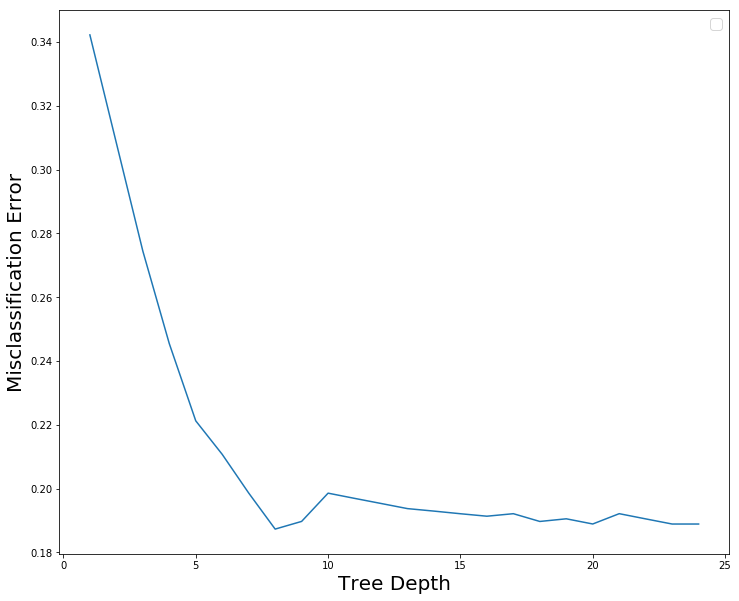

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=8, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)

Accuracy (f1 micro) on test set: 0.79
F1 micro on test set: 0.79
F1 macro on test set: 0.79

Confusion Matrix: 
[[230  60]
 [ 49 192]]

Classification Metrics: 
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       290
           1       0.76      0.80      0.78       241

   micro avg       0.79      0.79      0.79       531
   macro avg       0.79      0.79      0.79       531
weighted avg       0.80      0.79      0.80       531

Number of folds: 10
Best parameters set found on development set:
{'class_weight'

No handles with labels found to put in legend.


The optimal depth is:  17 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8111170207185943 



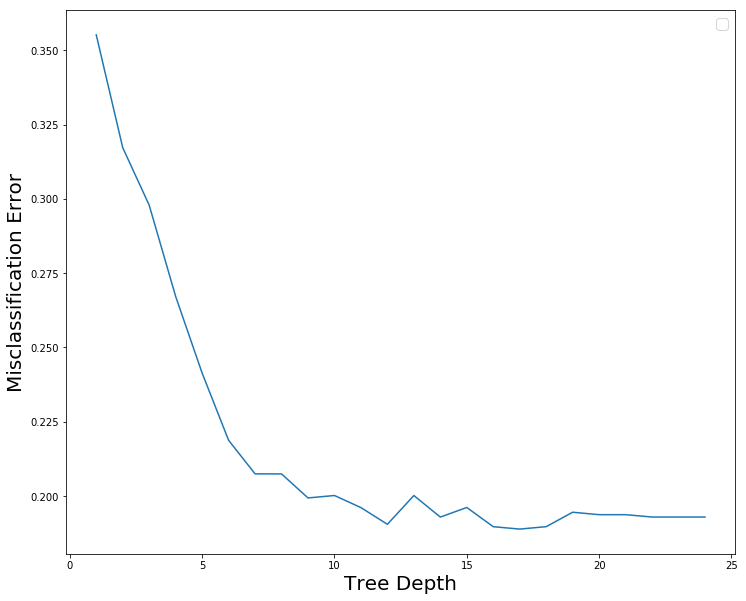

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=17, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)

Accuracy (f1 micro) on test set: 0.81
F1 micro on test set: 0.81
F1 macro on test set: 0.81

Confusion Matrix: 
[[242  48]
 [ 53 188]]

Classification Metrics: 
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       290
           1       0.80      0.78      0.79       241

   micro avg       0.81      0.81      0.81       531
   macro avg       0.81      0.81      0.81       531
weighted avg       0.81      0.81      0.81       531

Number of folds: 10
Best parameters set found on development set:
{'class_weight': 

No handles with labels found to put in legend.


The optimal depth is:  24 

Expected accuracy (f1 micro) based on Cross-Validation:  0.811956150013113 



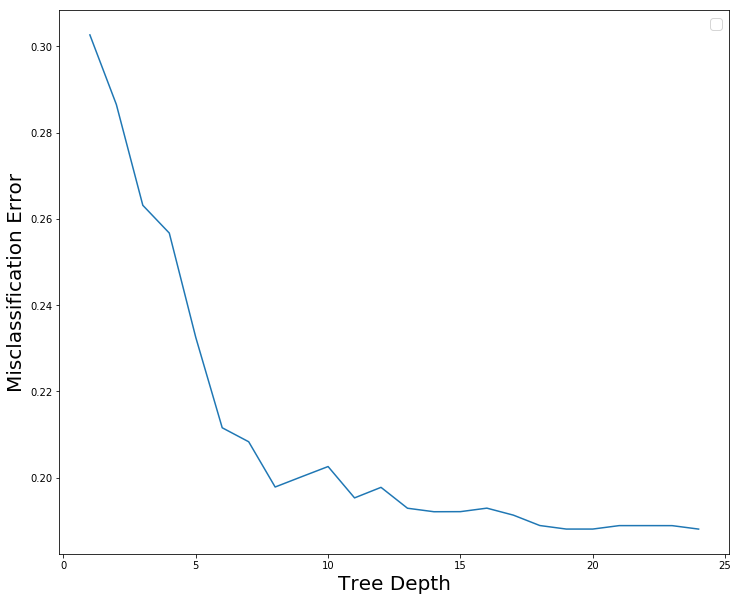

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=24, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)

Accuracy (f1 micro) on test set: 0.81
F1 micro on test set: 0.81
F1 macro on test set: 0.81

Confusion Matrix: 
[[236  54]
 [ 48 193]]

Classification Metrics: 
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       290
           1       0.78      0.80      0.79       241

   micro avg       0.81      0.81      0.81       531
   macro avg       0.81      0.81      0.81       531
weighted avg       0.81      0.81      0.81       531

Number of folds: 10
Best parameters set found on development set:
{'class_weigh

No handles with labels found to put in legend.


The optimal depth is:  23 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7974072383949646 



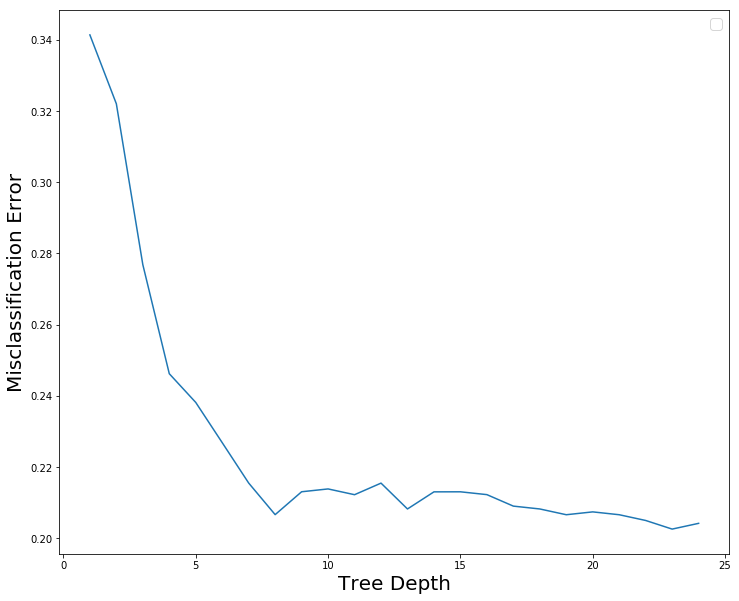

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=23, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)

Accuracy (f1 micro) on test set: 0.8
F1 micro on test set: 0.8
F1 macro on test set: 0.8

Confusion Matrix: 
[[235  55]
 [ 50 191]]

Classification Metrics: 
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       290
           1       0.78      0.79      0.78       241

   micro avg       0.80      0.80      0.80       531
   macro avg       0.80      0.80      0.80       531
weighted avg       0.80      0.80      0.80       531

Number of folds: 10
Best parameters set found on development set:
{'class_weight': 

No handles with labels found to put in legend.


The optimal depth is:  16 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7917749803304484 



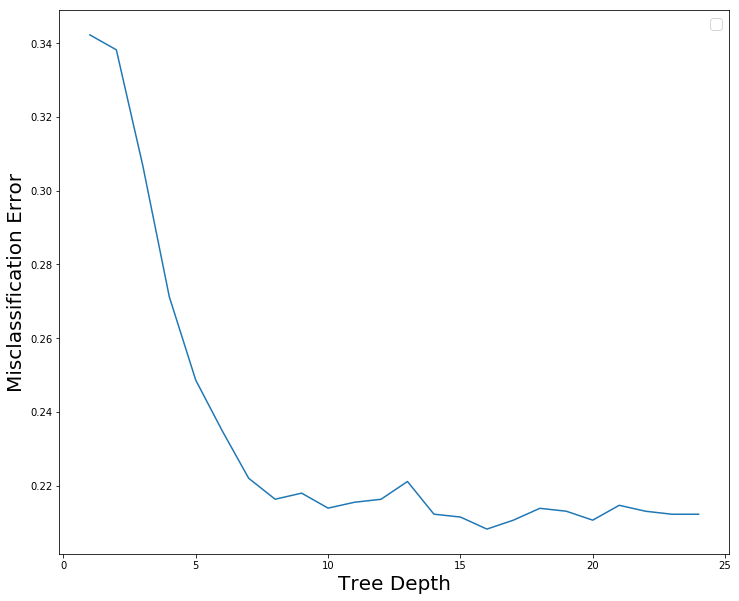

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=16, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)

Accuracy (f1 micro) on test set: 0.79
F1 micro on test set: 0.79
F1 macro on test set: 0.79

Confusion Matrix: 
[[231  59]
 [ 52 189]]

Classification Metrics: 
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       290
           1       0.76      0.78      0.77       241

   micro avg       0.79      0.79      0.79       531
   macro avg       0.79      0.79      0.79       531
weighted avg       0.79      0.79      0.79       531

Number of folds: 10
Best parameters set found on development set:
{'cl

No handles with labels found to put in legend.


The optimal depth is:  21 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7901296092315763 



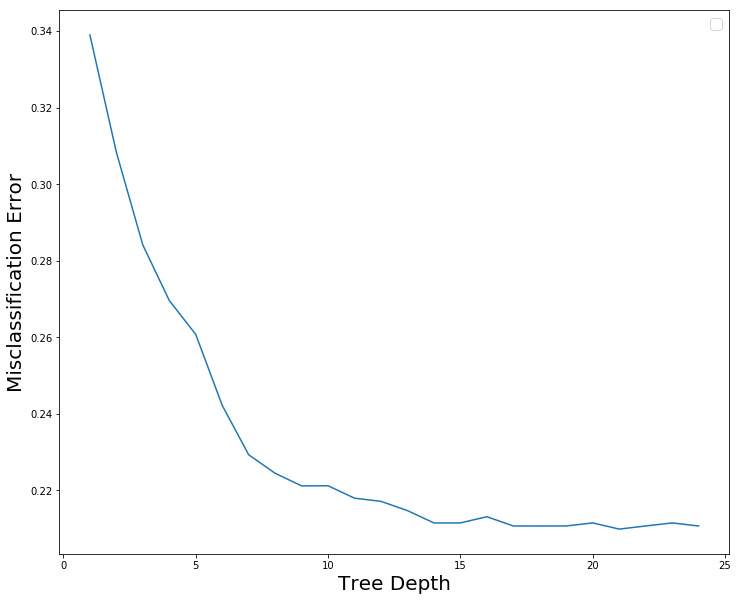

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=21, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)

Accuracy (f1 micro) on test set: 0.78
F1 micro on test set: 0.78
F1 macro on test set: 0.78

Confusion Matrix: 
[[220  70]
 [ 45 196]]

Classification Metrics: 
              precision    recall  f1-score   support

           0       0.83      0.76      0.79       290
           1       0.74      0.81      0.77       241

   micro avg       0.78      0.78      0.78       531
   macro avg       0.78      0.79      0.78       531
weighted avg       0.79      0.78      0.78       531

Number of folds: 10
Best parameters set found on development set:
{'class_weigh

No handles with labels found to put in legend.


The optimal depth is:  21 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7723801730920535 



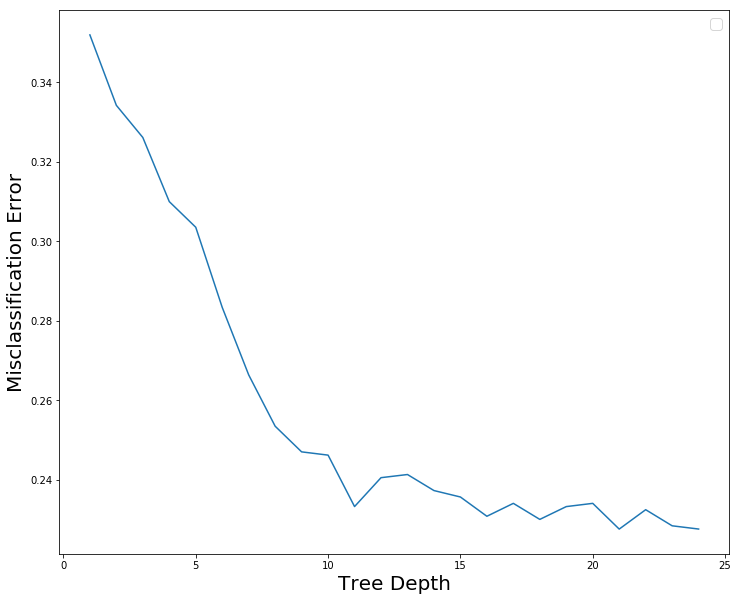

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=21, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)

Accuracy (f1 micro) on test set: 0.78
F1 micro on test set: 0.78
F1 macro on test set: 0.78

Confusion Matrix: 
[[232  58]
 [ 58 183]]

Classification Metrics: 
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       290
           1       0.76      0.76      0.76       241

   micro avg       0.78      0.78      0.78       531
   macro avg       0.78      0.78      0.78       531
weighted avg       0.78      0.78      0.78       531

Number of folds: 10
Best parameters set found on development set:
{'class_weight': 

No handles with labels found to put in legend.


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.6585783897193811 



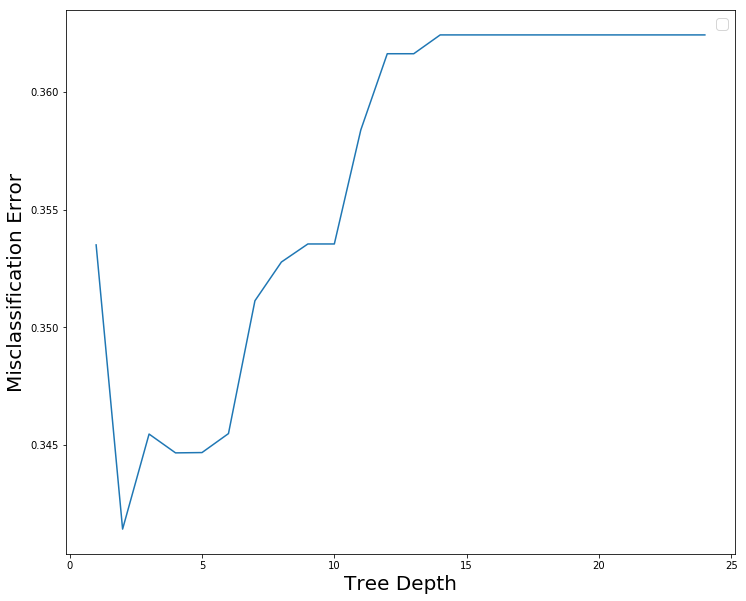

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=2, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=100, verbose=0, warm_start=False)

Accuracy (f1 micro) on test set: 0.7
F1 micro on test set: 0.7
F1 macro on test set: 0.7

Confusion Matrix: 
[[201  89]
 [ 72 169]]

Classification Metrics: 
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       290
           1       0.66      0.70      0.68       241

   micro avg       0.70      0.70      0.70       531
   macro avg       0.70      0.70      0.70       531
weighted avg       0.70      0.70      0.70       531



In [51]:
rf_acc_1b = learnRF(df_feature1_no_subjects_binary, num_feature_set1_no_subjects_binary, True) # featureset1
rf_acc_1b_to = learnRF(df_feature1_to_no_subjects_binary, num_feature_set1_to_no_subjects_binary, True) # featureset1
rf_acc_1b_rh = learnRF(df_feature1_rh_no_subjects_binary, num_feature_set1_rh_no_subjects_binary, True) # featureset1

rf_acc_2b = learnRF(df_feature2_no_subjects_binary, num_feature_set2_no_subjects_binary, True) # featureset2
rf_acc_2b_to = learnRF(df_feature2_to_no_subjects_binary, num_feature_set2_to_no_subjects_binary, True) # featureset2
rf_acc_2b_rh = learnRF(df_feature2_rh_no_subjects_binary, num_feature_set2_rh_no_subjects_binary, True) # featureset2

rf_acc_3b = learnRF(df_feature3_no_subjects_binary, num_feature_set3_no_subjects_binary, True) # featureset3
rf_acc_3b_b = learnRF(df_feature3b_no_subjects_binary, num_feature_set3b_no_subjects_binary, True) # featureset3b


### KNN

In [52]:
knn_acc_1b = learnKNN(df_feature1_no_subjects_binary, num_feature_set1_no_subjects_binary, True) # featureset1
knn_acc_1b_to = learnKNN(df_feature1_to_no_subjects_binary, num_feature_set1_to_no_subjects_binary, True) # featureset1
knn_acc_1b_rh = learnKNN(df_feature1_rh_no_subjects_binary, num_feature_set1_rh_no_subjects_binary, True) # featureset1

knn_acc_2b = learnKNN(df_feature2_no_subjects_binary, num_feature_set2_no_subjects_binary, True) # featureset2
knn_acc_2b_to = learnKNN(df_feature2_to_no_subjects_binary, num_feature_set2_to_no_subjects_binary, True) # featureset2
knn_acc_2b_rh = learnKNN(df_feature2_rh_no_subjects_binary, num_feature_set2_rh_no_subjects_binary, True) # featureset2

knn_acc_3b = learnKNN(df_feature3_no_subjects_binary, num_feature_set3_no_subjects_binary, True) # featureset3
knn_acc_3b_b = learnKNN(df_feature3b_no_subjects_binary, num_feature_set3b_no_subjects_binary, True) # featureset3b


Number of folds: 10
Best parameters set found on development set:
{'algorithm': 'brute', 'metric': 'seuclidean', 'n_neighbors': 7, 'weights': 'distance'}


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='seuclidean',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='distance')

Accuracy (f1 micro) on test set: 0.79
F1 micro on test set: 0.79
F1 macro on test set: 0.79

Confusion Matrix: 
[[229  61]
 [ 51 190]]

Classification Metrics: 
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       290
           1       0.76      0.79      0.77       241

   micro avg       0.79      0.79      0.79       531
   macro avg       0.79      0.79      0.79       531
weighted avg       0.79      0.79      0.79       531

Number of folds: 10
Best parameters set found on development set:
{'algorithm': 'brute', 'metric': 'seuclidean', 'n_neighbors': 9, 'weights': 'distance'}


KNeighborsClassifier(algorith

### SVM

In [53]:
svm_acc_1b = learnSVM(df_feature1_no_subjects_binary, num_feature_set1_no_subjects_binary, True) # featureset1
svm_acc_1b_to = learnSVM(df_feature1_to_no_subjects_binary, num_feature_set1_to_no_subjects_binary, True) # featureset1
svm_acc_1b_rh = learnSVM(df_feature1_rh_no_subjects_binary, num_feature_set1_rh_no_subjects_binary, True) # featureset1

svm_acc_2b = learnSVM(df_feature2_no_subjects_binary, num_feature_set2_no_subjects_binary, True) # featureset2
svm_acc_2b_to = learnSVM(df_feature2_to_no_subjects_binary, num_feature_set2_to_no_subjects_binary, True) # featureset2
svm_acc_2b_rh = learnSVM(df_feature2_rh_no_subjects_binary, num_feature_set2_rh_no_subjects_binary, True) # featureset2

svm_acc_3b = learnSVM(df_feature3_no_subjects_binary, num_feature_set3_no_subjects_binary, True) # featureset3
svm_acc_3b_b = learnSVM(df_feature3b_no_subjects_binary, num_feature_set3b_no_subjects_binary, True) # featureset3


Number of folds: 10
Best parameters set found on development set:
{'C': 100, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=100, shrinking=True,
  tol=0.001, verbose=False)

Accuracy (f1 micro) on test set: 0.77
F1 micro on test set: 0.77
F1 macro on test set: 0.77

Confusion Matrix: 
[[222  68]
 [ 52 189]]

Classification Metrics: 
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       290
           1       0.74      0.78      0.76       241

   micro avg       0.77      0.77      0.77       531
   macro avg       0.77      0.77      0.77       531
weighted avg       0.78      0.77      0.77       531

Number of folds: 10
Best parameters set found on development set:
{'C': 100, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


SVC(C=10

### Naive Bayes

In [54]:
nb_acc_1b = learnNB(df_feature1_no_subjects_binary, num_feature_set1_no_subjects_binary, True)
nb_acc_1b_to = learnNB(df_feature1_to_no_subjects_binary, num_feature_set1_to_no_subjects_binary, True)
nb_acc_1b_rh = learnNB(df_feature1_rh_no_subjects_binary, num_feature_set1_rh_no_subjects_binary, True)

nb_acc_2b = learnNB(df_feature2_no_subjects_binary, num_feature_set2_no_subjects_binary, True)
nb_acc_2b_to = learnNB(df_feature2_to_no_subjects_binary, num_feature_set2_to_no_subjects_binary, True)
nb_acc_2b_rh = learnNB(df_feature2_rh_no_subjects_binary, num_feature_set2_rh_no_subjects_binary, True)

nb_acc_3b = learnNB(df_feature3_no_subjects_binary, num_feature_set3_no_subjects_binary, True)
nb_acc_3b_b = learnNB(df_feature3b_no_subjects_binary, num_feature_set3b_no_subjects_binary, True)


Expected accuracy (f1 micro) based on Cross-Validation: 0.6432623655913978


GaussianNB(priors=None, var_smoothing=1e-09)

Accuracy (f1 micro) on test set: 0.66
F1 micro on test set: 0.66
F1 macro on test set: 0.66

Confusion Matrix: 
[[202  88]
 [ 92 149]]

Classification Metrics: 
              precision    recall  f1-score   support

           0       0.69      0.70      0.69       290
           1       0.63      0.62      0.62       241

   micro avg       0.66      0.66      0.66       531
   macro avg       0.66      0.66      0.66       531
weighted avg       0.66      0.66      0.66       531

Expected accuracy (f1 micro) based on Cross-Validation: 0.6189574613165487


GaussianNB(priors=None, var_smoothing=1e-09)

Accuracy (f1 micro) on test set: 0.64
F1 micro on test set: 0.64
F1 macro on test set: 0.63

Confusion Matrix: 
[[190 100]
 [ 93 148]]

Classification Metrics: 
              precision    recall  f1-score   support

           0       0.67      0.66      0.66       

### MLP

In [55]:
mlp_acc_1b = learnMLP(df_feature1_no_subjects_binary, num_feature_set1_no_subjects_binary, True)
mlp_acc_1b_to = learnMLP(df_feature1_to_no_subjects_binary, num_feature_set1_to_no_subjects_binary, True)
mlp_acc_1b_rh = learnMLP(df_feature1_rh_no_subjects_binary, num_feature_set1_rh_no_subjects_binary, True)

mlp_acc_2b = learnMLP(df_feature2_no_subjects_binary, num_feature_set2_no_subjects_binary, True)
mlp_acc_2b_to = learnMLP(df_feature2_to_no_subjects_binary, num_feature_set2_to_no_subjects_binary, True)
mlp_acc_2b_rh = learnMLP(df_feature2_rh_no_subjects_binary, num_feature_set2_rh_no_subjects_binary, True)

mlp_acc_3b = learnMLP(df_feature3_no_subjects_binary, num_feature_set3_no_subjects_binary, True)
mlp_acc_3b_b = learnMLP(df_feature3b_no_subjects_binary, num_feature_set3b_no_subjects_binary, True)


MLPClassifier(activation='tanh', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(11,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=300, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=100, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

Expected accuracy (f1 micro) based on Cross-Validation:  0.7328896407028587 


Accuracy (f1 micro) on test set: 0.75
F1 micro on test set: 0.75
F1 macro on test set: 0.74

Confusion Matrix: 
[[220  70]
 [ 65 176]]

Classification Metrics: 
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       290
           1       0.72      0.73      0.72       241

   micro avg       0.75      0.75      0.75       531
   macro avg       0.74      0.74      0.74       531
weighted avg       0.75      0.75  

### Result Plots


Accuracy (f1 micro) on test set: 0.55
F1 micro on test set: 0.55
F1 macro on test set: 0.14

Confusion Matrix: 
[[  0   0  59   0   0]
 [  0   0 122   0   0]
 [  0   0 290   0   0]
 [  0   0  49   0   0]
 [  0   0  11   0   0]]

Classification Metrics: 
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        59
          -1       0.00      0.00      0.00       122
           0       0.55      1.00      0.71       290
           1       0.00      0.00      0.00        49
           2       0.00      0.00      0.00        11

   micro avg       0.55      0.55      0.55       531
   macro avg       0.11      0.20      0.14       531
weighted avg       0.30      0.55      0.39       531

Metric: F1-score micro
Data Split: 30% Test, 70% Train


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predic

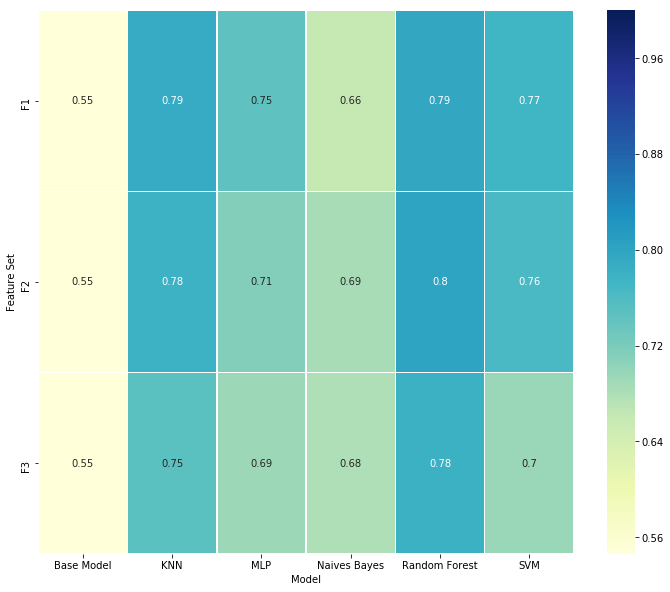

Target Labels:  [0 1]
Feature Set 1:  ['Temperature (Fahrenheit)', 'SkinTemperature', 'ClothingInsulation', 'Height(cm)', 'Shoulder Circumference(cm)', 'Weight(lbs)', 'Gender', 'Temperature_outside', 'Humidity_outside']
Feature Set 2:  ['Temperature (Fahrenheit)', 'Height(cm)', 'Shoulder Circumference(cm)', 'Temperature_outside', 'Humidity_outside']
Feature Set 3:  ['Temperature (Fahrenheit)', 'Temperature_outside', 'Humidity_outside']


In [56]:
# comparing base model
test_size_percentage = 0.3 # if changed, change in all places
base_model_pred_binary = np.zeros(int(round(len(df_feature1_no_subjects_binary) * test_size_percentage))) # comfort label is 0 in the dataset

X = np.array(df_feature1_no_subjects_binary.iloc[:, 0:num_feature_set1_no_subjects_binary])
y = np.array(df_feature1_no_subjects_binary['Discomfort'])
# split into train and test
test_size_percentage = 0.3 

base_model_acc_binary = getClfMetrics(y_test, base_model_pred_binary)

experiment_acc_both_features_binary = pd.DataFrame([['Random Forest', 'F1', rf_acc_1b], 
                                                    ['KNN', 'F1', knn_acc_1b],
                                                    ['SVM', 'F1', svm_acc_1b],
                                                    ['Naives Bayes', 'F1', nb_acc_1b],
                                                    ['MLP', 'F1', mlp_acc_1b],
                                                    ['Random Forest', 'F2', rf_acc_2b], 
                                                    ['KNN', 'F2', knn_acc_2b],
                                                    ['SVM', 'F2', svm_acc_2b],
                                                    ['Naives Bayes', 'F2', nb_acc_2b],
                                                    ['MLP', 'F2', mlp_acc_2b],
                                                    ['Random Forest', 'F3', rf_acc_3b], 
                                                    ['KNN', 'F3', knn_acc_3b],
                                                    ['SVM', 'F3', svm_acc_3b],
                                                    ['Naives Bayes', 'F3', nb_acc_3b],
                                                    ['MLP', 'F3', mlp_acc_3b],
                                                    ['Base Model', 'F1', base_model_acc],
                                                    ['Base Model', 'F2', base_model_acc],
                                                    ['Base Model', 'F3', base_model_acc]],
                                                    columns = ['Model', 'Feature Set', 'Accuracy'])

# plot heatmap
print("Metric: F1-score micro")
print("Data Split: 30% Test, 70% Train")
experiment_acc_both_features_binary = experiment_acc_both_features_binary.pivot("Feature Set", "Model", "Accuracy")
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(experiment_acc_both_features_binary, linewidths = 0.5, annot = True, vmax = 1, cmap = "YlGnBu")
plt.show()

print("Target Labels: ", df_feature1_no_subjects_binary['Discomfort'].unique())
print("Feature Set 1: ", feature_set1_no_subjects_binary)
print("Feature Set 2: ", feature_set2_no_subjects_binary)
print("Feature Set 3: ", feature_set3_no_subjects_binary)


## Aggregated Results

Metric: F1-score micro
Data Split: 30% Test, 70% Train


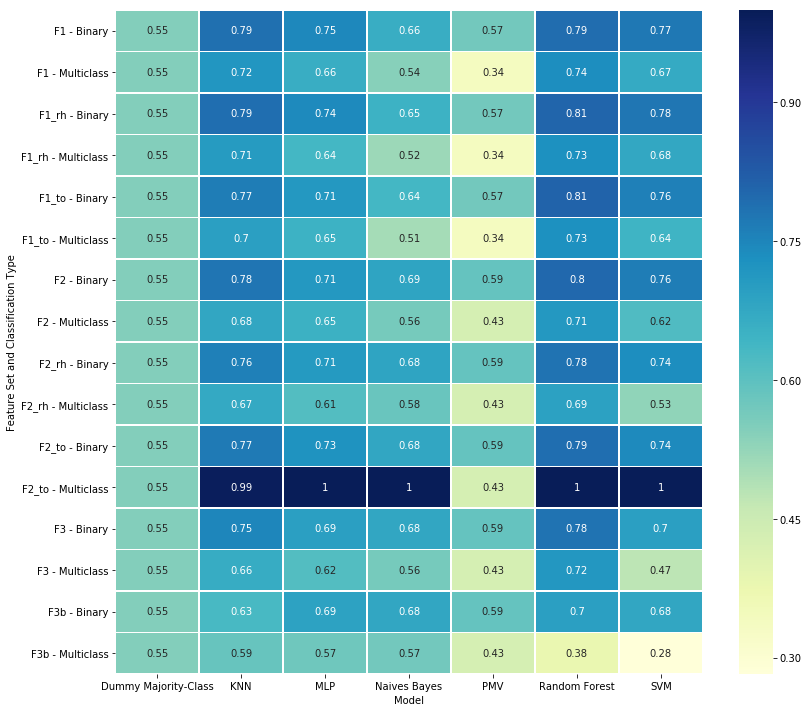

Target Labels Multiclass:  [ 0 -1 -2  1  2]
Target Labels Binary:  [0 1]
Feature Set 1:  ['Temperature (Fahrenheit)', 'SkinTemperature', 'ClothingInsulation', 'Height(cm)', 'Shoulder Circumference(cm)', 'Weight(lbs)', 'Gender', 'Temperature_outside', 'Humidity_outside']
Feature Set 2:  ['Temperature (Fahrenheit)', 'Height(cm)', 'Shoulder Circumference(cm)', 'Temperature_outside', 'Humidity_outside']
Feature Set 3:  ['Temperature (Fahrenheit)', 'Temperature_outside', 'Humidity_outside']


In [61]:

experiment_acc_all_participants = pd.DataFrame([['Random Forest', 'F1 - Multiclass', rf_acc_1], 
                                                ['KNN', 'F1 - Multiclass', knn_acc_1],
                                                ['SVM', 'F1 - Multiclass', svm_acc_1],
                                                ['Naives Bayes', 'F1 - Multiclass', nb_acc_1],
                                                ['MLP', 'F1 - Multiclass', mlp_acc_1],
                                                
                                                ['Random Forest', 'F1_to - Multiclass', rf_acc_1_to], 
                                                ['KNN', 'F1_to - Multiclass', knn_acc_1_to],
                                                ['SVM', 'F1_to - Multiclass', svm_acc_1_to],
                                                ['Naives Bayes', 'F1_to - Multiclass', nb_acc_1_to],
                                                ['MLP', 'F1_to - Multiclass', mlp_acc_1_to],

                                                ['Random Forest', 'F1_rh - Multiclass', rf_acc_1_rh], 
                                                ['KNN', 'F1_rh - Multiclass', knn_acc_1_rh],
                                                ['SVM', 'F1_rh - Multiclass', svm_acc_1_rh],
                                                ['Naives Bayes', 'F1_rh - Multiclass', nb_acc_1_rh],
                                                ['MLP', 'F1_rh - Multiclass', mlp_acc_1_rh],

                                                
                                                ['Random Forest', 'F2 - Multiclass', rf_acc_2], 
                                                ['KNN', 'F2 - Multiclass', knn_acc_2],
                                                ['SVM', 'F2 - Multiclass', svm_acc_2],
                                                ['Naives Bayes', 'F2 - Multiclass', nb_acc_2],
                                                ['MLP', 'F2 - Multiclass', mlp_acc_2],
                                                
                                                ['Random Forest', 'F2_to - Multiclass', rf_acc_2_to], 
                                                ['KNN', 'F2_to - Multiclass', knn_acc_2_to],
                                                ['SVM', 'F2_to - Multiclass', svm_acc_2_to],
                                                ['Naives Bayes', 'F2_to - Multiclass', nb_acc_2_to],
                                                ['MLP', 'F2_to - Multiclass', mlp_acc_2_to],
                                                
                                                ['Random Forest', 'F2_rh - Multiclass', rf_acc_2_rh], 
                                                ['KNN', 'F2_rh - Multiclass', knn_acc_2_rh],
                                                ['SVM', 'F2_rh - Multiclass', svm_acc_2_rh],
                                                ['Naives Bayes', 'F2_rh - Multiclass', nb_acc_2_rh],
                                                ['MLP', 'F2_rh - Multiclass', mlp_acc_2_rh],
                                                
                                                ['Random Forest', 'F3 - Multiclass', rf_acc_3], 
                                                ['KNN', 'F3 - Multiclass', knn_acc_3],
                                                ['SVM', 'F3 - Multiclass', svm_acc_3],
                                                ['Naives Bayes', 'F3 - Multiclass', nb_acc_3],
                                                ['MLP', 'F3 - Multiclass', mlp_acc_3],
                                                
                                                ['Random Forest', 'F3b - Multiclass', rf_acc_3_b], 
                                                ['KNN', 'F3b - Multiclass', knn_acc_3_b],
                                                ['SVM', 'F3b - Multiclass', svm_acc_3_b],
                                                ['Naives Bayes', 'F3b - Multiclass', nb_acc_3_b],
                                                ['MLP', 'F3b - Multiclass', mlp_acc_3_b],
                                                
                                                ['Random Forest', 'F1 - Binary', rf_acc_1b], 
                                                ['KNN', 'F1 - Binary', knn_acc_1b],
                                                ['SVM', 'F1 - Binary', svm_acc_1b],
                                                ['Naives Bayes', 'F1 - Binary', nb_acc_1b],
                                                ['MLP', 'F1 - Binary', mlp_acc_1b],
                                                
                                                ['Random Forest', 'F1_to - Binary', rf_acc_1b_to], 
                                                ['KNN', 'F1_to - Binary', knn_acc_1b_to],
                                                ['SVM', 'F1_to - Binary', svm_acc_1b_to],
                                                ['Naives Bayes', 'F1_to - Binary', nb_acc_1b_to],
                                                ['MLP', 'F1_to - Binary', mlp_acc_1b_to],
                                                
                                                ['Random Forest', 'F1_rh - Binary', rf_acc_1b_rh], 
                                                ['KNN', 'F1_rh - Binary', knn_acc_1b_rh],
                                                ['SVM', 'F1_rh - Binary', svm_acc_1b_rh],
                                                ['Naives Bayes', 'F1_rh - Binary', nb_acc_1b_rh],
                                                ['MLP', 'F1_rh - Binary', mlp_acc_1b_rh],
                                                
                                                ['Random Forest', 'F2 - Binary', rf_acc_2b],
                                                ['KNN', 'F2 - Binary', knn_acc_2b],
                                                ['SVM', 'F2 - Binary', svm_acc_2b],
                                                ['Naives Bayes', 'F2 - Binary', nb_acc_2b],
                                                ['MLP', 'F2 - Binary', mlp_acc_2b],
                                                
                                                ['Random Forest', 'F2_to - Binary', rf_acc_2b_to],
                                                ['KNN', 'F2_to - Binary', knn_acc_2b_to],
                                                ['SVM', 'F2_to - Binary', svm_acc_2b_to],
                                                ['Naives Bayes', 'F2_to - Binary', nb_acc_2b_to],
                                                ['MLP', 'F2_to - Binary', mlp_acc_2b_to],
                                                
                                                ['Random Forest', 'F2_rh - Binary', rf_acc_2b_rh],
                                                ['KNN', 'F2_rh - Binary', knn_acc_2b_rh],
                                                ['SVM', 'F2_rh - Binary', svm_acc_2b_rh],
                                                ['Naives Bayes', 'F2_rh - Binary', nb_acc_2b_rh],
                                                ['MLP', 'F2_rh - Binary', mlp_acc_2b_rh],
                                                
                                                ['Random Forest', 'F3 - Binary', rf_acc_3b], 
                                                ['KNN', 'F3 - Binary', knn_acc_3b],
                                                ['SVM', 'F3 - Binary', svm_acc_3b],
                                                ['Naives Bayes', 'F3 - Binary', nb_acc_3b],
                                                ['MLP', 'F3 - Binary', mlp_acc_3b],
                                                
                                                ['Random Forest', 'F3b - Binary', rf_acc_3b_b],
                                                ['KNN', 'F3b - Binary', knn_acc_3b_b],
                                                ['SVM', 'F3b - Binary', svm_acc_3b_b],
                                                ['Naives Bayes', 'F3b - Binary', nb_acc_3b_b],
                                                ['MLP', 'F3b - Binary', mlp_acc_3b_b],
                                                
                                                ['Dummy Majority-Class', 'F1 - Multiclass', base_model_acc],
                                                ['Dummy Majority-Class', 'F1_to - Multiclass', base_model_acc],
                                                ['Dummy Majority-Class', 'F1_rh - Multiclass', base_model_acc],
                                                ['Dummy Majority-Class', 'F2 - Multiclass', base_model_acc],
                                                ['Dummy Majority-Class', 'F2_to - Multiclass', base_model_acc],
                                                ['Dummy Majority-Class', 'F2_rh - Multiclass', base_model_acc],
                                                ['Dummy Majority-Class', 'F3 - Multiclass', base_model_acc],
                                                ['Dummy Majority-Class', 'F3b - Multiclass', base_model_acc],
                                                
                                                ['Dummy Majority-Class', 'F1 - Binary', base_model_acc_binary],
                                                ['Dummy Majority-Class', 'F1_to - Binary', base_model_acc_binary],
                                                ['Dummy Majority-Class', 'F1_rh - Binary', base_model_acc_binary],
                                                ['Dummy Majority-Class', 'F2 - Binary', base_model_acc_binary],
                                                ['Dummy Majority-Class', 'F2_to - Binary', base_model_acc_binary],
                                                ['Dummy Majority-Class', 'F2_rh - Binary', base_model_acc_binary],
                                                ['Dummy Majority-Class', 'F3 - Binary', base_model_acc_binary],
                                                ['Dummy Majority-Class', 'F3b - Binary', base_model_acc_binary],
                                                
                                                ['PMV', 'F1 - Binary', 0.57],
                                                ['PMV', 'F1_to - Binary', 0.57],
                                                ['PMV', 'F1_rh - Binary', 0.57],
                                                ['PMV', 'F2 - Binary', 0.59],
                                                ['PMV', 'F2_to - Binary', 0.59],
                                                ['PMV', 'F2_rh - Binary', 0.59],
                                                ['PMV', 'F3 - Binary', 0.59],
                                                ['PMV', 'F3b - Binary', 0.59],
                                                ['PMV', 'F1 - Multiclass', 0.34],
                                                ['PMV', 'F1_to - Multiclass', 0.34],
                                                ['PMV', 'F1_rh - Multiclass', 0.34],
                                                ['PMV', 'F2 - Multiclass', 0.43],
                                                ['PMV', 'F2_to - Multiclass', 0.43],
                                                ['PMV', 'F2_rh - Multiclass', 0.43],
                                                ['PMV', 'F3 - Multiclass', 0.43],
                                                ['PMV', 'F3b - Multiclass', 0.43]],
                                                columns = ['Model', 'Feature Set and Classification Type', 'Accuracy'])

# plot heatmap
print("Metric: F1-score micro")
print("Data Split: 30% Test, 70% Train")
experiment_acc_all_participants = experiment_acc_all_participants.pivot("Feature Set and Classification Type", "Model", "Accuracy")
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(experiment_acc_all_participants, linewidths = 0.5, annot = True, vmax = 1, cmap = "YlGnBu")
plt.tight_layout()
plt.show()

fig.savefig('heatmap_holistic_multipleFS.png', bbox_inches='tight')

print("Target Labels Multiclass: ", df_feature1_no_subjects['Discrete Thermal Comfort_TA'].unique())
print("Target Labels Binary: ", df_feature1_no_subjects_binary['Discomfort'].unique())
print("Feature Set 1: ", feature_set1_no_subjects_binary)
print("Feature Set 2: ", feature_set2_no_subjects_binary)
print("Feature Set 3: ", feature_set3_no_subjects_binary)


Metric: F1-score micro
Data Split: 30% Test, 70% Train


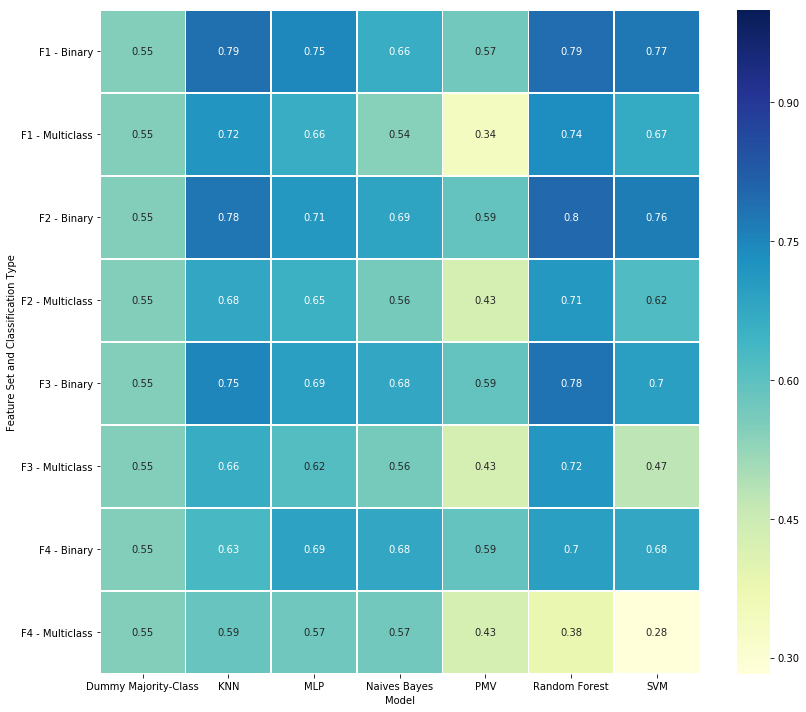

Target Labels Multiclass:  [ 0 -1 -2  1  2]
Target Labels Binary:  [0 1]
Feature Set 1:  ['Temperature (Fahrenheit)', 'SkinTemperature', 'ClothingInsulation', 'Height(cm)', 'Shoulder Circumference(cm)', 'Weight(lbs)', 'Gender', 'Temperature_outside', 'Humidity_outside']
Feature Set 2:  ['Temperature (Fahrenheit)', 'Height(cm)', 'Shoulder Circumference(cm)', 'Temperature_outside', 'Humidity_outside']
Feature Set 3:  ['Temperature (Fahrenheit)', 'Temperature_outside', 'Humidity_outside']


In [62]:

experiment_acc_all_participants = pd.DataFrame([['Random Forest', 'F1 - Multiclass', rf_acc_1], 
                                                ['KNN', 'F1 - Multiclass', knn_acc_1],
                                                ['SVM', 'F1 - Multiclass', svm_acc_1],
                                                ['Naives Bayes', 'F1 - Multiclass', nb_acc_1],
                                                ['MLP', 'F1 - Multiclass', mlp_acc_1],
                                                
                                                ['Random Forest', 'F2 - Multiclass', rf_acc_2], 
                                                ['KNN', 'F2 - Multiclass', knn_acc_2],
                                                ['SVM', 'F2 - Multiclass', svm_acc_2],
                                                ['Naives Bayes', 'F2 - Multiclass', nb_acc_2],
                                                ['MLP', 'F2 - Multiclass', mlp_acc_2],
                                                
                                                ['Random Forest', 'F3 - Multiclass', rf_acc_3], 
                                                ['KNN', 'F3 - Multiclass', knn_acc_3],
                                                ['SVM', 'F3 - Multiclass', svm_acc_3],
                                                ['Naives Bayes', 'F3 - Multiclass', nb_acc_3],
                                                ['MLP', 'F3 - Multiclass', mlp_acc_3],
                                                
                                                ['Random Forest', 'F4 - Multiclass', rf_acc_3_b], 
                                                ['KNN', 'F4 - Multiclass', knn_acc_3_b],
                                                ['SVM', 'F4 - Multiclass', svm_acc_3_b],
                                                ['Naives Bayes', 'F4 - Multiclass', nb_acc_3_b],
                                                ['MLP', 'F4 - Multiclass', mlp_acc_3_b],
                                                
                                                ['Random Forest', 'F1 - Binary', rf_acc_1b], 
                                                ['KNN', 'F1 - Binary', knn_acc_1b],
                                                ['SVM', 'F1 - Binary', svm_acc_1b],
                                                ['Naives Bayes', 'F1 - Binary', nb_acc_1b],
                                                ['MLP', 'F1 - Binary', mlp_acc_1b],
                                                                                                
                                                ['Random Forest', 'F2 - Binary', rf_acc_2b],
                                                ['KNN', 'F2 - Binary', knn_acc_2b],
                                                ['SVM', 'F2 - Binary', svm_acc_2b],
                                                ['Naives Bayes', 'F2 - Binary', nb_acc_2b],
                                                ['MLP', 'F2 - Binary', mlp_acc_2b],
                                                                                                
                                                ['Random Forest', 'F3 - Binary', rf_acc_3b], 
                                                ['KNN', 'F3 - Binary', knn_acc_3b],
                                                ['SVM', 'F3 - Binary', svm_acc_3b],
                                                ['Naives Bayes', 'F3 - Binary', nb_acc_3b],
                                                ['MLP', 'F3 - Binary', mlp_acc_3b],
                                                
                                                ['Random Forest', 'F4 - Binary', rf_acc_3b_b],
                                                ['KNN', 'F4 - Binary', knn_acc_3b_b],
                                                ['SVM', 'F4 - Binary', svm_acc_3b_b],
                                                ['Naives Bayes', 'F4 - Binary', nb_acc_3b_b],
                                                ['MLP', 'F4 - Binary', mlp_acc_3b_b],
                                                
                                                ['Dummy Majority-Class', 'F1 - Multiclass', base_model_acc],
                                                ['Dummy Majority-Class', 'F2 - Multiclass', base_model_acc],
                                                ['Dummy Majority-Class', 'F3 - Multiclass', base_model_acc],
                                                ['Dummy Majority-Class', 'F4 - Multiclass', base_model_acc],
                                                
                                                ['Dummy Majority-Class', 'F1 - Binary', base_model_acc_binary],
                                                ['Dummy Majority-Class', 'F2 - Binary', base_model_acc_binary],
                                                ['Dummy Majority-Class', 'F3 - Binary', base_model_acc_binary],
                                                ['Dummy Majority-Class', 'F4 - Binary', base_model_acc_binary],
                                                
                                                ['PMV', 'F1 - Binary', 0.57],
                                                ['PMV', 'F2 - Binary', 0.59],
                                                ['PMV', 'F3 - Binary', 0.59],
                                                ['PMV', 'F4 - Binary', 0.59],
                                                ['PMV', 'F1 - Multiclass', 0.34],
                                                ['PMV', 'F2 - Multiclass', 0.43],
                                                ['PMV', 'F3 - Multiclass', 0.43],
                                                ['PMV', 'F4 - Multiclass', 0.43]],
                                                columns = ['Model', 'Feature Set and Classification Type', 'Accuracy'])

# plot heatmap
print("Metric: F1-score micro")
print("Data Split: 30% Test, 70% Train")
experiment_acc_all_participants = experiment_acc_all_participants.pivot("Feature Set and Classification Type", "Model", "Accuracy")
fig = plt.figure(figsize=(12, 10))
ax = sns.heatmap(experiment_acc_all_participants, linewidths = 0.5, annot = True, vmax = 1, cmap = "YlGnBu")
plt.tight_layout()
plt.show()

fig.savefig('heatmap_holistic_4featuresets.png', bbox_inches='tight')

print("Target Labels Multiclass: ", df_feature1_no_subjects['Discrete Thermal Comfort_TA'].unique())
print("Target Labels Binary: ", df_feature1_no_subjects_binary['Discomfort'].unique())
print("Feature Set 1: ", feature_set1_no_subjects_binary)
print("Feature Set 2: ", feature_set2_no_subjects_binary)
print("Feature Set 3: ", feature_set3_no_subjects_binary)


## Personalised models, Multi-class classification problem

In [28]:
################################################ Feature set 1 ###############################################################
df_feature1_subjects = df_survey_feature_set1.copy()
    
# list of participants numbers in the dataset
participant_list = set(df_feature1_subjects['Participant_No'])
# print(participant_list)

# new set of features without the substracted features
feature_set1_subjects = list(df_feature1_subjects)[:-1]
num_feature_set1_subjects = len(feature_set1_subjects) - 1 # we do not use Participant_No as a feature
print("Feature Set 1 (with subjects): {}".format(feature_set1_subjects))
print("Number of features in this set: {}\n".format(num_feature_set1_subjects))

################################################ Feature set 2 ###############################################################
df_feature2_subjects = df_survey_feature_set2.copy()

# new set of features without the substracted features
feature_set2_subjects = list(df_feature2_subjects)[:-1]
num_feature_set2_subjects = len(feature_set2_subjects) - 1 # we do not use Participant_No as a feature
print("Feature Set 2 (with subjects): {}".format(feature_set2_subjects))
print("Number of features in this set: {}".format(num_feature_set2_subjects))

################################################ Feature set 3 ###############################################################
df_feature3_subjects = df_survey_feature_set3.copy()

# new set of features without the substracted features
feature_set3_subjects = list(df_feature3_subjects)[:-1]
num_feature_set3_subjects = len(feature_set3_subjects) - 1 # we do not use Participant_No as a feature
print("Feature Set 3 (with subjects): {}".format(feature_set3_subjects))
print("Number of features in this set: {}".format(num_feature_set3_subjects))


Feature Set 1 (with subjects): ['Participant_No', 'Temperature (Fahrenheit)', 'SkinTemperature', 'ClothingInsulation', 'Height(cm)', 'Shoulder Circumference(cm)', 'Weight(lbs)', 'Gender', 'Temperature_outside', 'Humidity_outside']
Number of features in this set: 9

Feature Set 2 (with subjects): ['Participant_No', 'Temperature (Fahrenheit)', 'Height(cm)', 'Shoulder Circumference(cm)', 'Temperature_outside', 'Humidity_outside']
Number of features in this set: 5
Feature Set 3 (with subjects): ['Participant_No', 'Temperature (Fahrenheit)', 'Temperature_outside', 'Humidity_outside']
Number of features in this set: 3


### Random Forest

In [29]:
dict_rf_classifier_acc1 = participantRF(df_feature1_subjects, num_feature_set1_subjects, participant_list)
dict_rf_classifier_acc2 = participantRF(df_feature2_subjects, num_feature_set2_subjects, participant_list)
dict_rf_classifier_acc3 = participantRF(df_feature3_subjects, num_feature_set3_subjects, participant_list)

Starting Participant 1
Number of folds: 10
Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  1.0 



Starting Participant 2
Participant 2 has label -2 as unitary class.

Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 100}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.888888888888889 



Starting Participant 4
Number of folds: 5


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 100}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.96 



Starting Participant 5
Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  4 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7566137566137566 



Starting Participant 6
Number of folds: 6


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'gini', 'min_samples_split': 10, 'n_estimators': 5}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8972222222222223 



Starting Participant 7
Number of folds: 5


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8666666666666666 



Starting Participant 8
Number of folds: 5


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  0.95 



Starting Participant 11
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.5625 



Starting Participant 12
Number of folds: 4


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  4 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7875 



Starting Participant 14
Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7666666666666666 



Starting Participant 15
Participant 15 has label 2 as unitary class.

Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.5227272727272727 



Starting Participant 16
Participant 16 only had one fold.

Starting Participant 17
Participant 17 has label -2 as unitary class.

Number of folds: 6


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8888888888888888 



Starting Participant 18
Participant 18 only had one fold.

Starting Participant 19
Participant 19 only had one fold.

Starting Participant 20
Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 1000}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8777777777777778 



Starting Participant 21
Number of folds: 3
Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 1000}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.9047619047619048 



Starting Participant 22
Number of folds: 5


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  1.0 



Starting Participant 23
Participant 23 has label 1 as unitary class.

Participant 23 only had one fold.

Starting Participant 24
Participant 24 has label -2 as unitary class.

Participant 24 only had one fold.

Starting Participant 25
Participant 25 only had one fold.

Starting Participant 27
Participant 27 only had one fold.

Starting Participant 29
Participant 29 only had one fold.

Starting Participant 30
Participant 30 only had one fold.

Starting Participant 31
Participant 31 has label 1 as unitary class.

Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 100}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.5357142857142857 



Starting Participant 32
Participant 32 only had one fold.

Starting Participant 33
Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7999999999999999 



Starting Participant 34
Participant 34 only had one fold.

Starting Participant 35
Number of folds: 3
Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  1.0 



Starting Participant 40
Number of folds: 5


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 100}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.95 



Starting Participant 41
Participant 41 has label -2 as unitary class.

Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 20, 'n_estimators': 1000}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.6686507936507936 



Starting Participant 42
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7388888888888889 



Starting Participant 43
Participant 43 has label -1 as unitary class.

Number of folds: 4


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7083333333333333 



Starting Participant 44
Number of folds: 6


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.9027777777777777 



Starting Participant 45
Number of folds: 4


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.95 



Starting Participant 46
Number of folds: 2
Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.9545454545454546 



Starting Participant 49
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8819444444444444 



Starting Participant 50
Participant 50 has label 1 as unitary class.

Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7904761904761904 



Starting Participant 51
Participant 51 has label -2 as unitary class.

Participant 51 only had one fold.

Starting Participant 52
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  1.0 



Starting Participant 54
Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 1000}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8412698412698413 



Starting Participant 55
Participant 55 has label 1 as unitary class.

Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8888888888888888 



Starting Participant 57
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.9545454545454546 



Starting Participant 58
Number of folds: 3
Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  1.0 



Starting Participant 59
Number of folds: 7
Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8571428571428571 



Starting Participant 60
Participant 60 has label 1 as unitary class.

Number of folds: 4


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  5 

Expected accuracy (f1 micro) based on Cross-Validation:  0.5666666666666667 



Starting Participant 61
Participant 61 has label 1 as unitary class.

Number of folds: 10


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 1000}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8 



Starting Participant 62
Participant 62 only had one fold.

Starting Participant 63
Participant 63 has label 1 as unitary class.

Number of folds: 7


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 10}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8333333333333333 



Starting Participant 64
Participant 64 only had one fold.

Starting Participant 65
Participant 65 has label 2 as unitary class.

Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  5 

Expected accuracy (f1 micro) based on Cross-Validation:  0.5932539682539683 



Starting Participant 66
Number of folds: 6


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8055555555555555 



Starting Participant 67
Participant 67 has label 2 as unitary class.

Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.6682539682539682 



Starting Participant 68
Number of folds: 8


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8333333333333333 



Starting Participant 70
Number of folds: 5


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 10}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8 



Starting Participant 71
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  1.0 



Starting Participant 72
Number of folds: 6
Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7777777777777777 



Starting Participant 73
Participant 73 has label -2 as unitary class.

Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.46825396825396826 



Starting Participant 74
Participant 74 only had one fold.

Starting Participant 75
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.6904761904761905 



Starting Participant 76
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8285714285714285 



Starting Participant 77
Participant 77 has label -2 as unitary class.

Number of folds: 9


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 10}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8703703703703703 



Starting Participant 78
Participant 78 has label -2 as unitary class.

Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  4 

Expected accuracy (f1 micro) based on Cross-Validation:  0.9045454545454545 



Starting Participant 79
Participant 79 only had one fold.

Starting Participant 80
Participant 80 only had one fold.

Starting Participant 1
Number of folds: 10
Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  1.0 



Starting Participant 2
Participant 2 has label -2 as unitary class.

Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8333333333333334 



Starting Participant 4
Number of folds: 5


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.96 



Starting Participant 5
Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'min_samples_split': 10, 'n_estimators': 100}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7195767195767195 



Starting Participant 6
Number of folds: 6


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8583333333333334 



Starting Participant 7
Number of folds: 5


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8666666666666666 



Starting Participant 8
Number of folds: 5


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  0.95 



Starting Participant 11
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.5 



Starting Participant 12
Number of folds: 4


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7375 



Starting Participant 14
Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  4 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8333333333333334 



Starting Participant 15
Participant 15 has label 2 as unitary class.

Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  4 

Expected accuracy (f1 micro) based on Cross-Validation:  0.5681818181818181 



Starting Participant 16
Participant 16 only had one fold.

Starting Participant 17
Participant 17 has label -2 as unitary class.

Number of folds: 6


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8055555555555555 



Starting Participant 18
Participant 18 only had one fold.

Starting Participant 19
Participant 19 only had one fold.

Starting Participant 20
Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.9333333333333332 



Starting Participant 21
Number of folds: 3
Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.9523809523809524 



Starting Participant 22
Number of folds: 5


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  1.0 



Starting Participant 23
Participant 23 has label 1 as unitary class.

Participant 23 only had one fold.

Starting Participant 24
Participant 24 has label -2 as unitary class.

Participant 24 only had one fold.

Starting Participant 25
Participant 25 only had one fold.

Starting Participant 27
Participant 27 only had one fold.

Starting Participant 29
Participant 29 only had one fold.

Starting Participant 30
Participant 30 only had one fold.

Starting Participant 31
Participant 31 has label 1 as unitary class.

Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 100}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.5357142857142857 



Starting Participant 32
Participant 32 only had one fold.

Starting Participant 33
Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8666666666666667 



Starting Participant 34
Participant 34 only had one fold.

Starting Participant 35
Number of folds: 3
Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.9166666666666666 



Starting Participant 40
Number of folds: 5


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.95 



Starting Participant 41
Participant 41 has label -2 as unitary class.

Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 20, 'n_estimators': 1000}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.6686507936507936 



Starting Participant 42
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  0.6333333333333333 



Starting Participant 43
Participant 43 has label -1 as unitary class.

Number of folds: 4


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7083333333333333 



Starting Participant 44
Number of folds: 6


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  4 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8888888888888888 



Starting Participant 45
Number of folds: 4


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.95 



Starting Participant 46
Number of folds: 2
Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.9090909090909091 



Starting Participant 49
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8819444444444444 



Starting Participant 50
Participant 50 has label 1 as unitary class.

Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 100}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.6761904761904761 



Starting Participant 51
Participant 51 has label -2 as unitary class.

Participant 51 only had one fold.

Starting Participant 52
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.875 



Starting Participant 54
Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 1000}


The optimal depth is:  4 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8968253968253969 



Starting Participant 55
Participant 55 has label 1 as unitary class.

Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8888888888888888 



Starting Participant 57
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  0.9045454545454545 



Starting Participant 58
Number of folds: 3
Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  1.0 



Starting Participant 59
Number of folds: 7
Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8095238095238095 



Starting Participant 60
Participant 60 has label 1 as unitary class.

Number of folds: 4


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 100}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.5666666666666667 



Starting Participant 61
Participant 61 has label 1 as unitary class.

Number of folds: 10


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8 



Starting Participant 62
Participant 62 only had one fold.

Starting Participant 63
Participant 63 has label 1 as unitary class.

Number of folds: 7


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8333333333333333 



Starting Participant 64
Participant 64 only had one fold.

Starting Participant 65
Participant 65 has label 2 as unitary class.

Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 1000}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.6071428571428571 



Starting Participant 66
Number of folds: 6


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'min_samples_split': 10, 'n_estimators': 1000}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.861111111111111 



Starting Participant 67
Participant 67 has label 2 as unitary class.

Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7047619047619048 



Starting Participant 68
Number of folds: 8


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 10}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8333333333333333 



Starting Participant 70
Number of folds: 5


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.85 



Starting Participant 71
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  1.0 



Starting Participant 72
Number of folds: 6
Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 100}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8888888888888888 



Starting Participant 73
Participant 73 has label -2 as unitary class.

Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  0.5793650793650793 



Starting Participant 74
Participant 74 only had one fold.

Starting Participant 75
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.746031746031746 



Starting Participant 76
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8285714285714285 



Starting Participant 77
Participant 77 has label -2 as unitary class.

Number of folds: 9


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 100}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8703703703703703 



Starting Participant 78
Participant 78 has label -2 as unitary class.

Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  0.9045454545454545 



Starting Participant 79
Participant 79 only had one fold.

Starting Participant 80
Participant 80 only had one fold.

Starting Participant 1
Number of folds: 10
Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  1.0 



Starting Participant 2
Participant 2 has label -2 as unitary class.

Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 10}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.888888888888889 



Starting Participant 4
Number of folds: 5


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.96 



Starting Participant 5
Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  4 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7301587301587302 



Starting Participant 6
Number of folds: 6


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8583333333333334 



Starting Participant 7
Number of folds: 5


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  5 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8666666666666666 



Starting Participant 8
Number of folds: 5


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.9166666666666667 



Starting Participant 11
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.5 



Starting Participant 12
Number of folds: 4


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  5 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7375 



Starting Participant 14
Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  4 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7000000000000001 



Starting Participant 15
Participant 15 has label 2 as unitary class.

Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  4 

Expected accuracy (f1 micro) based on Cross-Validation:  0.5181818181818182 



Starting Participant 16
Participant 16 only had one fold.

Starting Participant 17
Participant 17 has label -2 as unitary class.

Number of folds: 6


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  0.861111111111111 



Starting Participant 18
Participant 18 only had one fold.

Starting Participant 19
Participant 19 only had one fold.

Starting Participant 20
Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8777777777777778 



Starting Participant 21
Number of folds: 3
Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 1000}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.9523809523809524 



Starting Participant 22
Number of folds: 5


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  1.0 



Starting Participant 23
Participant 23 has label 1 as unitary class.

Participant 23 only had one fold.

Starting Participant 24
Participant 24 has label -2 as unitary class.

Participant 24 only had one fold.

Starting Participant 25
Participant 25 only had one fold.

Starting Participant 27
Participant 27 only had one fold.

Starting Participant 29
Participant 29 only had one fold.

Starting Participant 30
Participant 30 only had one fold.

Starting Participant 31
Participant 31 has label 1 as unitary class.

Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 100}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.5357142857142857 



Starting Participant 32
Participant 32 only had one fold.

Starting Participant 33
Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8666666666666667 



Starting Participant 34
Participant 34 only had one fold.

Starting Participant 35
Number of folds: 3
Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.9166666666666666 



Starting Participant 40
Number of folds: 5


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.95 



Starting Participant 41
Participant 41 has label -2 as unitary class.

Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 20, 'n_estimators': 1000}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.6686507936507936 



Starting Participant 42
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  0.6333333333333333 



Starting Participant 43
Participant 43 has label -1 as unitary class.

Number of folds: 4


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7083333333333333 



Starting Participant 44
Number of folds: 6


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.9444444444444443 



Starting Participant 45
Number of folds: 4


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.95 



Starting Participant 46
Number of folds: 2
Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.9090909090909091 



Starting Participant 49
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8819444444444444 



Starting Participant 50
Participant 50 has label 1 as unitary class.

Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 10}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7904761904761904 



Starting Participant 51
Participant 51 has label -2 as unitary class.

Participant 51 only had one fold.

Starting Participant 52
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.875 



Starting Participant 54
Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}


The optimal depth is:  4 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8968253968253969 



Starting Participant 55
Participant 55 has label 1 as unitary class.

Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8888888888888888 



Starting Participant 57
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.9045454545454545 



Starting Participant 58
Number of folds: 3
Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  1.0 



Starting Participant 59
Number of folds: 7
Best parameters set found on development set:
{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8095238095238095 



Starting Participant 60
Participant 60 has label 1 as unitary class.

Number of folds: 4


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 100}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.4666666666666667 



Starting Participant 61
Participant 61 has label 1 as unitary class.

Number of folds: 10


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8 



Starting Participant 62
Participant 62 only had one fold.

Starting Participant 63
Participant 63 has label 1 as unitary class.

Number of folds: 7


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 5}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8333333333333333 



Starting Participant 64
Participant 64 only had one fold.

Starting Participant 65
Participant 65 has label 2 as unitary class.

Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.5515873015873015 



Starting Participant 66
Number of folds: 6


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 1000}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.861111111111111 



Starting Participant 67
Participant 67 has label 2 as unitary class.

Number of folds: 3


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7238095238095238 



Starting Participant 68
Number of folds: 8


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 10}


The optimal depth is:  1 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8333333333333333 



Starting Participant 70
Number of folds: 5


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8 



Starting Participant 71
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  1.0 



Starting Participant 72
Number of folds: 6
Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  0.7777777777777777 



Starting Participant 73
Participant 73 has label -2 as unitary class.

Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.5793650793650793 



Starting Participant 74
Participant 74 only had one fold.

Starting Participant 75
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  0.746031746031746 



Starting Participant 76
Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 10}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.6857142857142857 



Starting Participant 77
Participant 77 has label -2 as unitary class.

Number of folds: 9


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 100}


The optimal depth is:  2 

Expected accuracy (f1 micro) based on Cross-Validation:  0.8703703703703703 



Starting Participant 78
Participant 78 has label -2 as unitary class.

Number of folds: 2


/Users/matias/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'class_weight': 'balanced', 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 5}


The optimal depth is:  3 

Expected accuracy (f1 micro) based on Cross-Validation:  0.9045454545454545 



Starting Participant 79
Participant 79 only had one fold.

Starting Participant 80
Participant 80 only had one fold.



### KNN

### SVM

### Naive Bayes

### MLP

### Results

Target Labels: [ 0 -1 -2  1  2]
Feature Set 1: ['Participant_No', 'Temperature (Fahrenheit)', 'SkinTemperature', 'ClothingInsulation', 'Height(cm)', 'Shoulder Circumference(cm)', 'Weight(lbs)', 'Gender', 'Temperature_outside', 'Humidity_outside']
Feature Set 2: ['Participant_No', 'Temperature (Fahrenheit)', 'Height(cm)', 'Shoulder Circumference(cm)', 'Temperature_outside', 'Humidity_outside']
Feature Set 3: ['Participant_No', 'Temperature (Fahrenheit)', 'Temperature_outside', 'Humidity_outside']

Metric: F1-score micro
Data Split: 30% Test, 70% Train
Classification Model Random Forest


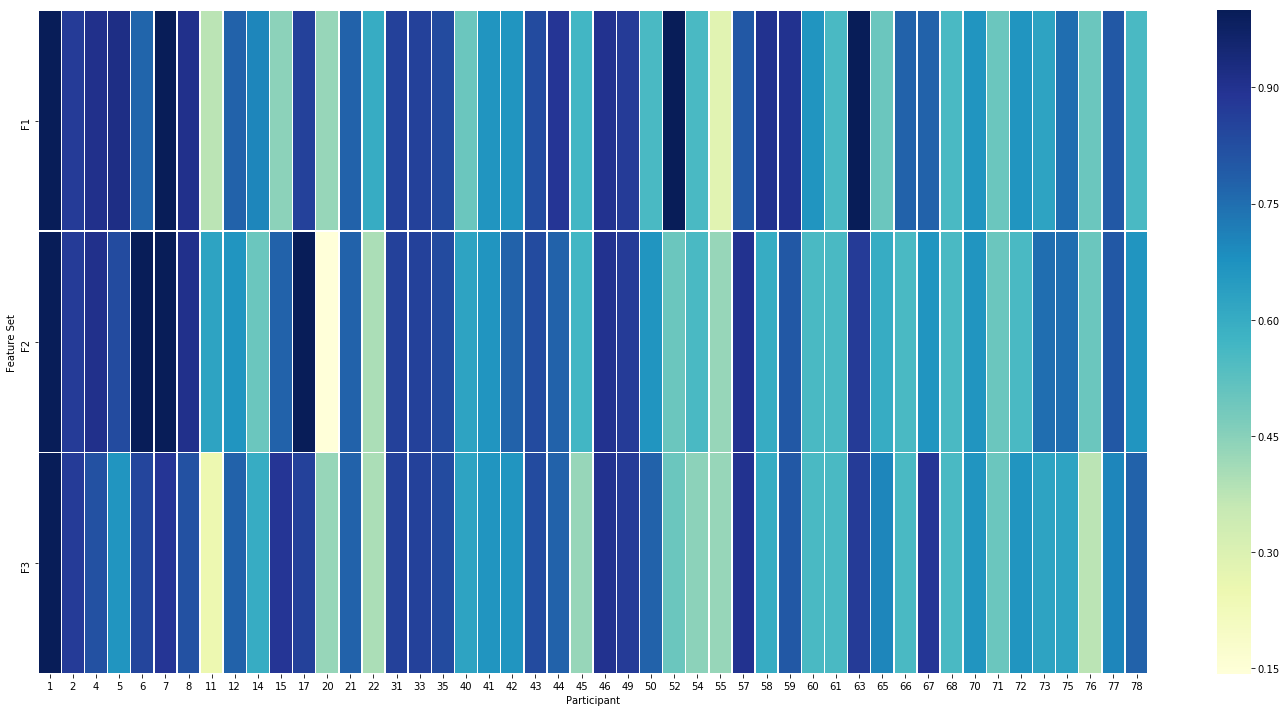

In [30]:
print("Target Labels: {}".format(df_feature1_subjects['Discrete Thermal Comfort_TA'].unique()))
print("Feature Set 1: {}".format(feature_set1_subjects))
print("Feature Set 2: {}".format(feature_set2_subjects))
print("Feature Set 3: {}\n".format(feature_set3_subjects))

# plot heatmap
print("Metric: F1-score micro")
print("Data Split: 30% Test, 70% Train")

# Random Forest
print("Classification Model Random Forest")
personalized_acc_all_features_set = pd.DataFrame(columns = ['Participant', 'Accuracy', 'Feature Set'])

index = 0
for key, value in dict_rf_classifier_acc1.items():
    personalized_acc_all_features_set.loc[index] = [key, value, 'F1']
    index = index + 1
    
for key, value in dict_rf_classifier_acc2.items():
    personalized_acc_all_features_set.loc[index] = [key, value, 'F2']
    index = index + 1

for key, value in dict_rf_classifier_acc3.items():
    personalized_acc_all_features_set.loc[index] = [key, value, 'F3']
    index = index + 1

personalized_acc_all_features_set = personalized_acc_all_features_set.pivot("Feature Set", "Participant", "Accuracy")
fig = plt.figure(figsize=(20, 10))
ax = sns.heatmap(personalized_acc_all_features_set, linewidths = 0.5, annot = False, vmax = 1, cmap = "YlGnBu")
plt.tight_layout()
plt.show()

fig.savefig('heatmap_personalized_outsideData.png', bbox_inches='tight')


# # KNN
# print "Classification Model KNN"
# personalized_acc_all_features_set = pd.DataFrame(columns = ['Participant', 'Accuracy', 'Feature Set'])

# index = 0
# for key, value in dict_knn_classifier_acc1.items():
#     personalized_acc_all_features_set.loc[index] = [key, value, 'F1']
#     index = index + 1
    
# for key, value in dict_knn_classifier_acc2.iteritems():
#     personalized_acc_all_features_set.loc[index] = [key, value, 'F2']
#     index = index + 1

# for key, value in dict_knn_classifier_acc3.iteritems():
#     personalized_acc_all_features_set.loc[index] = [key, value, 'F3']
#     index = index + 1

# personalized_acc_all_features_set = personalized_acc_all_features_set.pivot("Feature Set", "Participant", "Accuracy")
# fig = plt.figure(figsize=(20, 10))
# ax = sns.heatmap(personalized_acc_all_features_set, linewidths = 0.5, annot = False, vmax = 1, cmap = "YlGnBu")
# plt.show()

# # SVM
# print "Classification Model SVM"
# personalized_acc_all_features_set = pd.DataFrame(columns = ['Participant', 'Accuracy', 'Feature Set'])

# index = 0
# for key, value in dict_svm_classifier_acc1.items():
#     personalized_acc_all_features_set.loc[index] = [key, value, 'F1']
#     index = index + 1
    
# for key, value in dict_svm_classifier_acc2.iteritems():
#     personalized_acc_all_features_set.loc[index] = [key, value, 'F2']
#     index = index + 1

# for key, value in dict_svm_classifier_acc3.iteritems():
#     personalized_acc_all_features_set.loc[index] = [key, value, 'F3']
#     index = index + 1

# personalized_acc_all_features_set = personalized_acc_all_features_set.pivot("Feature Set", "Participant", "Accuracy")
# fig = plt.figure(figsize=(20, 10))
# ax = sns.heatmap(personalized_acc_all_features_set, linewidths = 0.5, annot = False, vmax = 1, cmap = "YlGnBu")
# plt.show()

# # Naive Bayes
# print "Classification Model Naive Bayes"
# personalized_acc_all_features_set = pd.DataFrame(columns = ['Participant', 'Accuracy', 'Feature Set'])

# index = 0
# for key, value in dict_nb_classifier_acc1.items():
#     personalized_acc_all_features_set.loc[index] = [key, value, 'F1']
#     index = index + 1
    
# for key, value in dict_nb_classifier_acc2.iteritems():
#     personalized_acc_all_features_set.loc[index] = [key, value, 'F2']
#     index = index + 1

# for key, value in dict_nb_classifier_acc3.iteritems():
#     personalized_acc_all_features_set.loc[index] = [key, value, 'F3']
#     index = index + 1

# personalized_acc_all_features_set = personalized_acc_all_features_set.pivot("Feature Set", "Participant", "Accuracy")
# fig = plt.figure(figsize=(20, 10))
# ax = sns.heatmap(personalized_acc_all_features_set, linewidths = 0.5, annot = False, vmax = 1, cmap = "YlGnBu")
# plt.show()

# # MLP
# print "Classification Model MLP"
# personalized_acc_all_features_set = pd.DataFrame(columns = ['Participant', 'Accuracy', 'Feature Set'])

# index = 0
# for key, value in dict_mlp_classifier_acc1.items():
#     personalized_acc_all_features_set.loc[index] = [key, value, 'F1']
#     index = index + 1
    
# for key, value in dict_mlp_classifier_acc2.iteritems():
#     personalized_acc_all_features_set.loc[index] = [key, value, 'F2']
#     index = index + 1

# for key, value in dict_mlp_classifier_acc3.iteritems():
#     personalized_acc_all_features_set.loc[index] = [key, value, 'F3']
#     index = index + 1

# personalized_acc_all_features_set = personalized_acc_all_features_set.pivot("Feature Set", "Participant", "Accuracy")
# fig = plt.figure(figsize=(20, 10))
# ax = sns.heatmap(personalized_acc_all_features_set, linewidths = 0.5, annot = False, vmax = 1, cmap = "YlGnBu")
# plt.show()
